# Build your `Deep Convolutional Generative Adversarial Network (DCGAN)` for Deep Learning on Handwritten Digits `Image generation` Task

## Task Overview 
<img src="https://miro.medium.com/max/1400/1*N3nT9AXVnsFBta2R1eEMjg.png" width="500">
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　<strong>A Task Schema Diagram</strong>
                                              
Generative Adversarial Networks (GANs) is a framework to train generative models, such as deep convolutional neural networks for generating images. GAN composed of two models which are trained simultaneously by an adversarial process. A generator model ("the artist") learns to create fake images that look real, while a discriminator model ("the art critic") learns to tell real images apart from fakes. 

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can hardly distinguish real images from fakes.

For a simple GAN the generator is build as a simple fully connected network. The generator of a Deep Convolutional Generative Adversarial Network (DCGAN) are mainly composes of convolution layers without max pooling with convolutional stride and transposed convolution (Fractionally-strided convolution or Deconvolution) for the downsampling and the upsampling of 2D images.  
 

You will conduct a `Image generation` task, by `building` a DCGAN architecture with Python to generate `fake images` from random `noise input`, that after proper `training` of the model it would look like images of `real handwritten digits`. 

The `TensorFlow 2.x` platform and its integrated version of `Keras API` (versus the traditional Keras Package) should be the handy tools for you to complete this task. Please take advantage of the official well supported TensorFlow & Keras [`Help Documentations`](https://www.tensorflow.org/api_docs/python/tf/keras) for correct usages of the API and functions. 


In [1]:
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers, optimizers

import numpy as np

import matplotlib.pyplot as plt 

2023-07-10 18:08:01.823220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Record the starting time of runing DCGAN project
## Create a image folder to store generated fake images for every interval during training
import os
from datetime import datetime
datetime_now = datetime.now()
print(f"DCGAN Project starts at {datetime_now}")
datetime_now = datetime_now.strftime("%Y%d%m_%H%M%S")
if os.path.exists('dcgan_fake_images'):       
    os.rename("dcgan_fake_images", f"dcgan_fake_images_{datetime_now}")    
    os.makedirs('dcgan_fake_images')
else:        
    os.makedirs('dcgan_fake_images')

DCGAN Project starts at 2023-06-01 12:37:56.998149


## Prepare Dataset 

### The Image Dataset of MNIST Handwritten Digits - Introduction 

The [`MNIST`](http://yann.lecun.com/exdb/mnist/) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is widely used for training and testing Deep Learning Models.

The images in the dataset contains small square images with pixels in grayscale, and each image present a real handwritten single digits between 0 and 9.  

The image genration task is to generate fake images out of noise inputs and have the fake images looks like a handwritten digit.

### Load Data

Load the MNIST dataset distributed with Keras.
  

In [2]:
## Load the MNIST data from the Keras in Tensorflow framework
mnist_data = keras.datasets.mnist
  
## We will only use the images to train the DCGAN, so use '_' to replace other variable locations
##   Since we are not trying to train model to classify into correct labels 
##   We only need to identify if a image is real or fake as 1 or 0

(images_train, _),(_, _) = mnist_data.load_data()

###  Explore Data

In [3]:
print(type(images_train))
print(images_train.shape)
print(np.min(images_train), np.max(images_train))

<class 'numpy.ndarray'>
(60000, 28, 28)
0 255


In [4]:
## Define a function for visualizing some images
def images_show(images, dim=(1,6), figsize=(12,6), num_postfix=-1):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], cmap='Greys_r', interpolation='nearest')
        plt.axis('off') 
    plt.savefig(f'dcgan_fake_images/fake_images_iter_{num_postfix:05d}.png') 
    plt.pause(0.1)

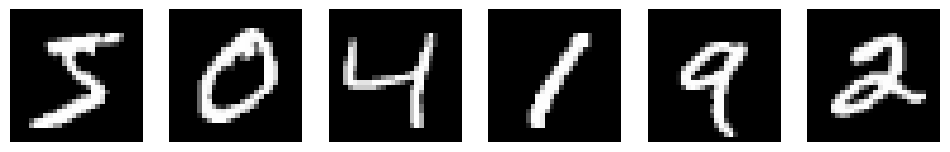

In [5]:
loaded_image_samples = images_train[:6] 
images_show(loaded_image_samples)  

### Preprocess data

In [6]:
## To faciliate the model training, we would preprocess to normalize and reshape the images

def images_preprocess(images):
    ## Normalize the input images to the range of [-1, 1] 
    images = images / 127.5 - 1
    
    ## Convert dimension of all grayscale images to be enforce to have a color channel in its dimensions
    ##   i.e. convert origianl 3D tensor (number_of_data, image_height, image_width) of `images_train`
    ##        to 4D tensor by adding the addiontal dimension as the color channel
    images = images.reshape(60000, 28, 28, 1).astype('float32')       
    return images

## Use the function images_preprocess to preprocess the loaded data `images_train`  
images_preprocessed = images_preprocess(images_train)  
    

### Prepare dataset

In [7]:
## Prepare dataset from the preprocessed image data by shuffle and batch 

BUFFER_SIZE = 60000   
    
BATCH_SIZE = 64

## create dataset for real images 
images_data = tf.data.Dataset.from_tensor_slices(images_preprocessed)
def get_dataset_real(dataset, buffer=BUFFER_SIZE, batch=BATCH_SIZE, drop_remainder = True):
    ## Shuffle and Batch to prepare the dataset for real images
    dataset = dataset.shuffle(buffer).batch(batch, drop_remainder = drop_remainder).prefetch(1)
    return dataset

2023-07-10 18:10:06.944761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
## create noises for generating fake images during the training stage
 
## use a 1D random vector as the noise input 

NOISE_SIZE = 100

## create a batch of random vectors that each is in the range of [-1, 1] (as noises)  
##   i.e. random vectors for one batch
def get_noise_one_batch(batch_size=BATCH_SIZE, noise_size=NOISE_SIZE):
    noice_one_batch = np.random.uniform(-1, 1, (batch_size, noise_size))
    return noice_one_batch


## Build architecture of your DCGAN model

DCGAN is based on GAN, which composed of two models in neural networks:

- The first model is called a **Generator** and it aims to generate new data similar to the real one. In DCGAN it would generate an unexisted image that we call fake image for this project. 

- The second model is named the **Discriminator** and it aims to recognize if a data is ‘real’ — belongs to the original dataset; Or if it is ‘fake’ — generated by a forger. Whose output is a binary 1 or 0.



The basic building block of neural network is the layer. 
You will configure each layer of your model, then compiling the model.



<br>

For this task you are required to chain together layers as the architecture of the DCGAN. 

**Besides the layers you've already practiced and familiared with** in the **previous assignments** (E.g. **Dense, Convolutional, Flatten** layers etc.), 

the following  [**new types of layers**](https://www.tensorflow.org/api_docs/python/tf/keras/layers) might also needed in this task. Their API references listed below (as how to apply their corresponding **parameters** to configure the layer) might provide you more inspirations.

- [Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape)

- [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)

- [LeakyReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)


 

 




### Build the Generator Model


This Generator Model will receive noise vectors as inputs, and generated fake images as output;

A vector in the inputs would be converted and upsampled several times until reaching the same size of a real image.  

In [9]:
## Build a Generator model by stacking keras layers sequentially  
 
generator = keras.Sequential([        

    layers.Dense(7*7*128, input_shape=(NOISE_SIZE,), use_bias=True),   

    layers.Reshape([7, 7, 128]), 
    
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),

    layers.BatchNormalization(),  
 
    layers.LeakyReLU(alpha=0.2), 

    layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False),

    layers.BatchNormalization(), 

    layers.LeakyReLU(alpha=0.2),

    layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'),

    layers.Reshape([28, 28, 1])
])


### Build the Discriminator Model


This Discriminator Model in DCGAN is basically a normal **CNN*** (So you could **recall how you build your CNN model in previous assignment**) that can be trained for binary classification, to identify real or fake images. 

The Discriminator Model will receive images as inputs, and binary values 1 or 0 as the outputs, representing the classification of the input images to be real or fake. 

In [10]:
## set the input dimension for Discriminator Model
##   to the image shape in the tensor format (image_height, image_width, color_channels)
image_dim =(28, 28, 1)


# Build a tf.keras.Sequential model by stacking layers

discriminator = keras.Sequential([      

    
    layers.Conv2D(64, (5, 5), strides=(2, 2), input_shape=image_dim, padding='same'),

    layers.LeakyReLU(alpha=0.2),

    layers.Dropout(0.3),    

    layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'), 

    layers.LeakyReLU(alpha=0.2), 

    layers.Dropout(0.3),    

    layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'),       
    layers.LeakyReLU(alpha=0.2),      
    layers.Dropout(0.3),     
    
    
    layers.Flatten(),    
   
    layers.Dense(units=1, activation='sigmoid')    

])


##### Compile Discriminator Model first 

Before the model is ready for training, it needs a few more settings. These are to be added during the [model's compiling](https://www.tensorflow.org/api_docs/python/tf/keras/Model) step:

- [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) : This is how the model is updated based on the data it sees and its loss function.
- [Loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses) : This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction. 

Choose your optimizer:

In [11]:
my_optimizer = optimizers.Adam(learning_rate=0.0001)

Compile Discriminator Model:

In [12]:
## Compile the Discriminator model with your chosen optimizer, 
##   and use Binary cross-entropy as losses, 
discriminator.compile(optimizer=my_optimizer,
        loss=keras.losses.BinaryCrossentropy()
       )                     

 
### Build the DCGAN Model


Build the DCGAN by concatenating the Generator and Discriminator into one sequential.

The DCGAN Model will receive noise vectors as inputs, and a binary values 1 or 0 as the outputs, representing the classification of the input images to be real or fake.

The Generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the Discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples. 

In [13]:
## make discriminator not-trainable as of now
discriminator.trainable = False

## Combine both Generator and Discriminator Models
dcgan = keras.Sequential([     
    generator,   
    discriminator      
])


##### Compile DCGAN  

And then compile the whole DCGAN 

In [14]:
## Compile the DCGAN model as a whole with your chosen optimizer, 
##   and use Binary cross-entropy as losses, 
dcgan.compile(optimizer=my_optimizer,
        loss=keras.losses.BinaryCrossentropy()
       )  

## Train the model

Train the DCGAN to improve the ability of generating good fake images by the Generator.

Prepare 6 random noice vectors, to check and compare how the generated fake images on same 6 inputs are improved over the training procedure.


1/1 [==============================] - 0s 153ms/step


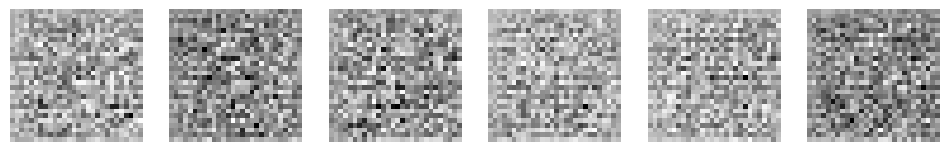

In [15]:
## create random noice inputs to checking the corresponding generated fake images 

## create random noise inputs of 6
##    which will be later used for comparison of the generated images
##    on these same sample noises during the training 
noise_inputs_check = get_noise_one_batch(6)  
## generate the initial output images before training
images_outputs_check = generator.predict(noise_inputs_check)

## Show the 6 generated images: 
images_show(images_outputs_check, num_postfix=-1) 

##### Train Discriminator Model and DCGAN Model  

In each training loop, the Discriminator Model is first trained to better classify real images (drawn from the real image dataset ) and fakes images (produced by the Generator Model based on random noice as input). 

The Discriminator in DCGAN was first marked as not trainable to train only weights of layers in the Generator of DCGAN Model to help better generate fake images like real. 

In [16]:
## Define training parameters  

## set epochs size/count 
EPOCHS = 20


## Calculated the Number of batches based on the loaded data `images_train`  and the size of a batch
BATCHS = np.floor(BUFFER_SIZE/BATCH_SIZE).astype('int')

## Set the interval as 300 
##   to show generated images by the Generator trained so far in the training procedure
##   on the same 6 noise vector inputs.
##   i.e. Display every 300 iterations the 6 generated fake images as training keeps improving it
iter_interval = 300

## Define binary labels that represent real and fake outputs for each batch training
labels_real = np.ones((BATCH_SIZE, 1))
labels_fake = np.zeros((BATCH_SIZE, 1))

~~~ DCGAN training starting at 2023-06-01 16:15:40.692323 

 
2/2 [==============================] - 0s 42ms/step
=== Iter: 5 : d_loss_real: 0.455173850, d_loss_fake: 0.700311065, dcg_loss: 0.539160669 - in Epoch 1/20 - Batch 5/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 10 : d_loss_real: 0.214291289, d_loss_fake: 0.709925056, dcg_loss: 0.358596623 - in Epoch 1/20 - Batch 10/937
2/2 [==============================] - 0s 33ms/step
=== Iter: 15 : d_loss_real: 0.058344632, d_loss_fake: 0.724705458, dcg_loss: 0.155242026 - in Epoch 1/20 - Batch 15/937
2/2 [==============================] - 0s 84ms/step
=== Iter: 20 : d_loss_real: 0.013672923, d_loss_fake: 0.736446857, dcg_loss: 0.060256686 - in Epoch 1/20 - Batch 20/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 25 : d_loss_real: 0.007662650, d_loss_fake: 0.726642907, dcg_loss: 0.043145619 - in Epoch 1/20 - Batch 25/937
2/2 [==============================] - 0s 34ms/step
=== Iter: 30 : d_loss_real: 

2/2 [==============================] - 0s 37ms/step
=== Iter: 220 : d_loss_real: 0.000733213, d_loss_fake: 0.001961309, dcg_loss: 0.018748999 - in Epoch 1/20 - Batch 220/937
2/2 [==============================] - 0s 39ms/step
=== Iter: 225 : d_loss_real: 0.001480429, d_loss_fake: 0.003929961, dcg_loss: 0.009350657 - in Epoch 1/20 - Batch 225/937
2/2 [==============================] - 0s 37ms/step
=== Iter: 230 : d_loss_real: 0.000030500, d_loss_fake: 0.176402658, dcg_loss: 0.056525663 - in Epoch 1/20 - Batch 230/937
2/2 [==============================] - 0s 48ms/step
=== Iter: 235 : d_loss_real: 0.000000207, d_loss_fake: 0.631963491, dcg_loss: 0.000687268 - in Epoch 1/20 - Batch 235/937
2/2 [==============================] - 0s 47ms/step
=== Iter: 240 : d_loss_real: 0.002343318, d_loss_fake: 0.272041202, dcg_loss: 0.000400534 - in Epoch 1/20 - Batch 240/937
2/2 [==============================] - 0s 37ms/step
=== Iter: 245 : d_loss_real: 0.267941326, d_loss_fake: 0.017656025, dcg_loss: 

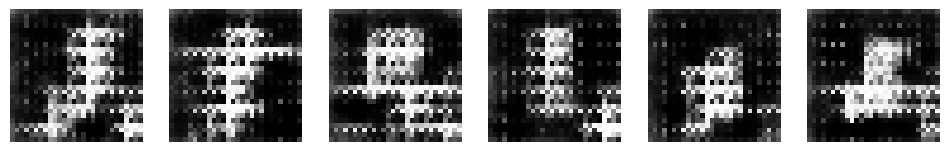

*** time now:  2023-06-01 16:18:18.470522
2/2 [==============================] - 0s 39ms/step
=== Iter: 305 : d_loss_real: 0.187047213, d_loss_fake: 0.221409619, dcg_loss: 1.184859514 - in Epoch 1/20 - Batch 305/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 310 : d_loss_real: 0.173865974, d_loss_fake: 0.198324710, dcg_loss: 1.715699911 - in Epoch 1/20 - Batch 310/937
2/2 [==============================] - 0s 39ms/step
=== Iter: 315 : d_loss_real: 0.168768331, d_loss_fake: 0.180290893, dcg_loss: 2.095893383 - in Epoch 1/20 - Batch 315/937
2/2 [==============================] - 0s 64ms/step
=== Iter: 320 : d_loss_real: 0.228047311, d_loss_fake: 0.226284683, dcg_loss: 1.825132370 - in Epoch 1/20 - Batch 320/937
2/2 [==============================] - 0s 47ms/step
=== Iter: 325 : d_loss_real: 0.188474253, d_loss_fake: 0.194154203, dcg_loss: 2.725045681 - in Epoch 1/20 - Batch 325/937
2/2 [==============================] - 0s 37ms/step
=== Iter: 330 : d_loss_real: 0.34009

2/2 [==============================] - 0s 89ms/step
=== Iter: 520 : d_loss_real: 0.659446716, d_loss_fake: 0.576006234, dcg_loss: 1.225442648 - in Epoch 1/20 - Batch 520/937
2/2 [==============================] - 0s 34ms/step
=== Iter: 525 : d_loss_real: 0.631060839, d_loss_fake: 0.554582119, dcg_loss: 1.248955846 - in Epoch 1/20 - Batch 525/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 530 : d_loss_real: 0.521098018, d_loss_fake: 0.545433760, dcg_loss: 1.258262753 - in Epoch 1/20 - Batch 530/937
2/2 [==============================] - 0s 32ms/step
=== Iter: 535 : d_loss_real: 0.489268124, d_loss_fake: 0.463182181, dcg_loss: 1.379332066 - in Epoch 1/20 - Batch 535/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 540 : d_loss_real: 0.420946240, d_loss_fake: 0.383156359, dcg_loss: 1.438313723 - in Epoch 1/20 - Batch 540/937
2/2 [==============================] - 0s 36ms/step
=== Iter: 545 : d_loss_real: 0.506472588, d_loss_fake: 0.466718376, dcg_loss: 

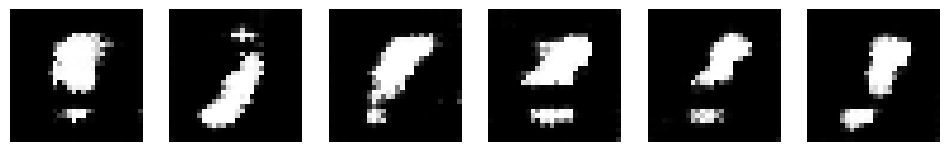

*** time now:  2023-06-01 16:21:48.966689
2/2 [==============================] - 0s 27ms/step
=== Iter: 605 : d_loss_real: 0.682363510, d_loss_fake: 0.641420305, dcg_loss: 1.222260952 - in Epoch 1/20 - Batch 605/937
2/2 [==============================] - 0s 28ms/step
=== Iter: 610 : d_loss_real: 0.634367824, d_loss_fake: 0.753041625, dcg_loss: 1.213841915 - in Epoch 1/20 - Batch 610/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 615 : d_loss_real: 0.866170406, d_loss_fake: 0.646038175, dcg_loss: 0.957881689 - in Epoch 1/20 - Batch 615/937
2/2 [==============================] - 0s 34ms/step
=== Iter: 620 : d_loss_real: 0.657374084, d_loss_fake: 0.706260443, dcg_loss: 0.973102748 - in Epoch 1/20 - Batch 620/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 625 : d_loss_real: 0.774060369, d_loss_fake: 0.644336641, dcg_loss: 0.912878513 - in Epoch 1/20 - Batch 625/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 630 : d_loss_real: 0.79945

2/2 [==============================] - 0s 34ms/step
=== Iter: 820 : d_loss_real: 0.733015060, d_loss_fake: 0.736535311, dcg_loss: 0.835314035 - in Epoch 1/20 - Batch 820/937
2/2 [==============================] - 0s 33ms/step
=== Iter: 825 : d_loss_real: 0.744583607, d_loss_fake: 0.716414034, dcg_loss: 0.748329759 - in Epoch 1/20 - Batch 825/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 830 : d_loss_real: 0.657426000, d_loss_fake: 0.686410904, dcg_loss: 0.800696313 - in Epoch 1/20 - Batch 830/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 835 : d_loss_real: 0.814175487, d_loss_fake: 0.680351734, dcg_loss: 0.791845441 - in Epoch 1/20 - Batch 835/937
2/2 [==============================] - 0s 34ms/step
=== Iter: 840 : d_loss_real: 0.704243481, d_loss_fake: 0.652391076, dcg_loss: 0.790254474 - in Epoch 1/20 - Batch 840/937
2/2 [==============================] - 0s 32ms/step
=== Iter: 845 : d_loss_real: 0.750141263, d_loss_fake: 0.735804200, dcg_loss: 

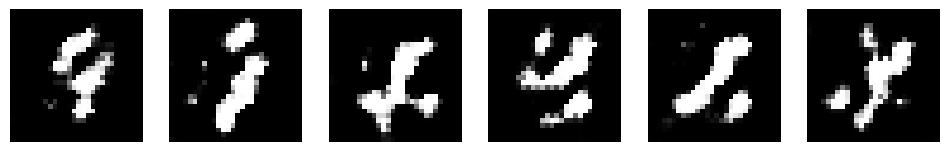

*** time now:  2023-06-01 16:24:02.910431
2/2 [==============================] - 0s 65ms/step
=== Iter: 905 : d_loss_real: 0.686246455, d_loss_fake: 0.628073394, dcg_loss: 0.819547951 - in Epoch 1/20 - Batch 905/937
2/2 [==============================] - 0s 80ms/step
=== Iter: 910 : d_loss_real: 0.661292076, d_loss_fake: 0.681965947, dcg_loss: 0.727821350 - in Epoch 1/20 - Batch 910/937
2/2 [==============================] - 0s 79ms/step
=== Iter: 915 : d_loss_real: 0.618130803, d_loss_fake: 0.649749517, dcg_loss: 0.772382379 - in Epoch 1/20 - Batch 915/937
2/2 [==============================] - 0s 68ms/step
=== Iter: 920 : d_loss_real: 0.710853338, d_loss_fake: 0.696717262, dcg_loss: 0.867372394 - in Epoch 1/20 - Batch 920/937
2/2 [==============================] - 0s 86ms/step
=== Iter: 925 : d_loss_real: 0.735494733, d_loss_fake: 0.623905897, dcg_loss: 0.822525144 - in Epoch 1/20 - Batch 925/937
2/2 [==============================] - 0s 87ms/step
=== Iter: 930 : d_loss_real: 0.72120

=== Iter: 1115 : d_loss_real: 0.609536946, d_loss_fake: 0.651041031, dcg_loss: 0.775241733 - in Epoch 2/20 - Batch 178/937
2/2 [==============================] - 0s 75ms/step
=== Iter: 1120 : d_loss_real: 0.699894011, d_loss_fake: 0.643068850, dcg_loss: 0.809095144 - in Epoch 2/20 - Batch 183/937
2/2 [==============================] - 0s 36ms/step
=== Iter: 1125 : d_loss_real: 0.678263664, d_loss_fake: 0.683292389, dcg_loss: 0.785295129 - in Epoch 2/20 - Batch 188/937
2/2 [==============================] - 0s 36ms/step
=== Iter: 1130 : d_loss_real: 0.655758083, d_loss_fake: 0.669652164, dcg_loss: 0.763031960 - in Epoch 2/20 - Batch 193/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 1135 : d_loss_real: 0.645662308, d_loss_fake: 0.672844172, dcg_loss: 0.726453125 - in Epoch 2/20 - Batch 198/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 1140 : d_loss_real: 0.594925404, d_loss_fake: 0.685209215, dcg_loss: 0.789873362 - in Epoch 2/20 - Batch 203/937
2/

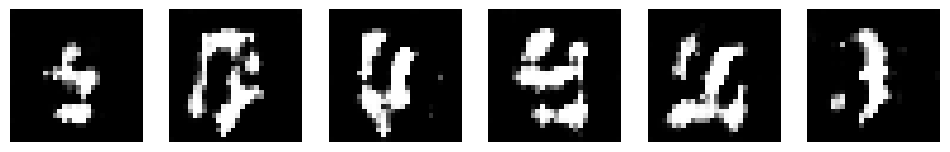

*** time now:  2023-06-01 16:27:23.081162
2/2 [==============================] - 0s 53ms/step
=== Iter: 1205 : d_loss_real: 0.659452796, d_loss_fake: 0.781767130, dcg_loss: 0.718407512 - in Epoch 2/20 - Batch 268/937
2/2 [==============================] - 0s 41ms/step
=== Iter: 1210 : d_loss_real: 0.699794888, d_loss_fake: 0.658805907, dcg_loss: 0.749433935 - in Epoch 2/20 - Batch 273/937
2/2 [==============================] - 0s 44ms/step
=== Iter: 1215 : d_loss_real: 0.720083594, d_loss_fake: 0.687067091, dcg_loss: 0.685762823 - in Epoch 2/20 - Batch 278/937
2/2 [==============================] - 0s 36ms/step
=== Iter: 1220 : d_loss_real: 0.759809315, d_loss_fake: 0.694574594, dcg_loss: 0.692391336 - in Epoch 2/20 - Batch 283/937
2/2 [==============================] - 0s 56ms/step
=== Iter: 1225 : d_loss_real: 0.673979700, d_loss_fake: 0.708920002, dcg_loss: 0.724551916 - in Epoch 2/20 - Batch 288/937
2/2 [==============================] - 0s 54ms/step
=== Iter: 1230 : d_loss_real: 0

2/2 [==============================] - 0s 22ms/step
=== Iter: 1415 : d_loss_real: 0.678701818, d_loss_fake: 0.704967976, dcg_loss: 0.732855022 - in Epoch 2/20 - Batch 478/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 1420 : d_loss_real: 0.678269863, d_loss_fake: 0.712301373, dcg_loss: 0.761320353 - in Epoch 2/20 - Batch 483/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 1425 : d_loss_real: 0.715692580, d_loss_fake: 0.665142834, dcg_loss: 0.776309252 - in Epoch 2/20 - Batch 488/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 1430 : d_loss_real: 0.688955307, d_loss_fake: 0.680143356, dcg_loss: 0.776609600 - in Epoch 2/20 - Batch 493/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 1435 : d_loss_real: 0.717574000, d_loss_fake: 0.711868763, dcg_loss: 0.716502428 - in Epoch 2/20 - Batch 498/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 1440 : d_loss_real: 0.703611195, d_loss_fake: 0.748841405, dcg_

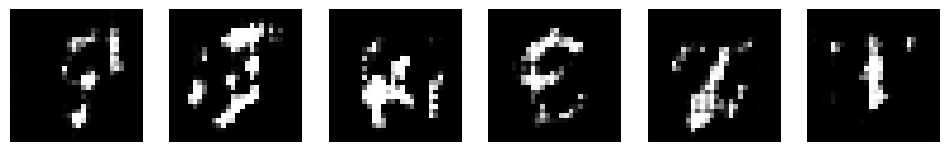

*** time now:  2023-06-01 16:29:50.479059
2/2 [==============================] - 0s 20ms/step
=== Iter: 1505 : d_loss_real: 0.693781376, d_loss_fake: 0.603205502, dcg_loss: 0.839375556 - in Epoch 2/20 - Batch 568/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 1510 : d_loss_real: 0.630911946, d_loss_fake: 0.650178671, dcg_loss: 0.811629355 - in Epoch 2/20 - Batch 573/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 1515 : d_loss_real: 0.649740160, d_loss_fake: 0.632281482, dcg_loss: 0.846000135 - in Epoch 2/20 - Batch 578/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 1520 : d_loss_real: 0.653733969, d_loss_fake: 0.659608722, dcg_loss: 0.810264230 - in Epoch 2/20 - Batch 583/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 1525 : d_loss_real: 0.611222863, d_loss_fake: 0.672344565, dcg_loss: 0.817385912 - in Epoch 2/20 - Batch 588/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 1530 : d_loss_real: 0

2/2 [==============================] - 0s 22ms/step
=== Iter: 1715 : d_loss_real: 0.701547027, d_loss_fake: 0.706176400, dcg_loss: 0.720757723 - in Epoch 2/20 - Batch 778/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 1720 : d_loss_real: 0.734686911, d_loss_fake: 0.694896579, dcg_loss: 0.723097086 - in Epoch 2/20 - Batch 783/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 1725 : d_loss_real: 0.668064773, d_loss_fake: 0.712719798, dcg_loss: 0.744846404 - in Epoch 2/20 - Batch 788/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 1730 : d_loss_real: 0.724113047, d_loss_fake: 0.664133668, dcg_loss: 0.766226590 - in Epoch 2/20 - Batch 793/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 1735 : d_loss_real: 0.676293373, d_loss_fake: 0.713701546, dcg_loss: 0.704845548 - in Epoch 2/20 - Batch 798/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 1740 : d_loss_real: 0.703889608, d_loss_fake: 0.691495419, dcg_

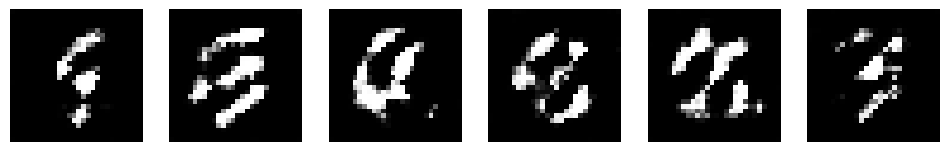

*** time now:  2023-06-01 16:31:17.344002
2/2 [==============================] - 0s 27ms/step
=== Iter: 1805 : d_loss_real: 0.710011482, d_loss_fake: 0.657358706, dcg_loss: 0.810531259 - in Epoch 2/20 - Batch 868/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 1810 : d_loss_real: 0.675498426, d_loss_fake: 0.685659826, dcg_loss: 0.859346747 - in Epoch 2/20 - Batch 873/937
2/2 [==============================] - 0s 28ms/step
=== Iter: 1815 : d_loss_real: 0.651926517, d_loss_fake: 0.654394269, dcg_loss: 0.878265321 - in Epoch 2/20 - Batch 878/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 1820 : d_loss_real: 0.662690639, d_loss_fake: 0.578085840, dcg_loss: 0.855401456 - in Epoch 2/20 - Batch 883/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 1825 : d_loss_real: 0.658508599, d_loss_fake: 0.612840414, dcg_loss: 0.811107755 - in Epoch 2/20 - Batch 888/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 1830 : d_loss_real: 0

2/2 [==============================] - 0s 23ms/step
=== Iter: 2020 : d_loss_real: 0.651926279, d_loss_fake: 0.647407293, dcg_loss: 0.830778480 - in Epoch 3/20 - Batch 146/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 2025 : d_loss_real: 0.712648273, d_loss_fake: 0.722733378, dcg_loss: 0.747942805 - in Epoch 3/20 - Batch 151/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 2030 : d_loss_real: 0.678309202, d_loss_fake: 0.786960125, dcg_loss: 0.660724998 - in Epoch 3/20 - Batch 156/937
2/2 [==============================] - 0s 31ms/step
=== Iter: 2035 : d_loss_real: 0.722760439, d_loss_fake: 0.724189341, dcg_loss: 0.705179095 - in Epoch 3/20 - Batch 161/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 2040 : d_loss_real: 0.725986183, d_loss_fake: 0.778428793, dcg_loss: 0.691229463 - in Epoch 3/20 - Batch 166/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 2045 : d_loss_real: 0.737817347, d_loss_fake: 0.760552287, dcg_

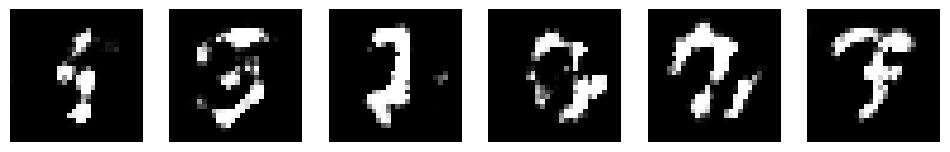

*** time now:  2023-06-01 16:33:31.734513
2/2 [==============================] - 0s 23ms/step
=== Iter: 2105 : d_loss_real: 0.742473722, d_loss_fake: 0.732934356, dcg_loss: 0.778555751 - in Epoch 3/20 - Batch 231/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 2110 : d_loss_real: 0.712138414, d_loss_fake: 0.668793321, dcg_loss: 0.768650174 - in Epoch 3/20 - Batch 236/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 2115 : d_loss_real: 0.691253781, d_loss_fake: 0.647345781, dcg_loss: 0.820346594 - in Epoch 3/20 - Batch 241/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 2120 : d_loss_real: 0.784230471, d_loss_fake: 0.706557035, dcg_loss: 0.794069886 - in Epoch 3/20 - Batch 246/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 2125 : d_loss_real: 0.653540075, d_loss_fake: 0.641917408, dcg_loss: 0.884607911 - in Epoch 3/20 - Batch 251/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 2130 : d_loss_real: 0

2/2 [==============================] - 0s 23ms/step
=== Iter: 2315 : d_loss_real: 0.526085913, d_loss_fake: 0.481117696, dcg_loss: 1.042634249 - in Epoch 3/20 - Batch 441/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 2320 : d_loss_real: 0.485772371, d_loss_fake: 0.487528056, dcg_loss: 0.986471415 - in Epoch 3/20 - Batch 446/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 2325 : d_loss_real: 0.572188139, d_loss_fake: 0.574542761, dcg_loss: 0.951468229 - in Epoch 3/20 - Batch 451/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 2330 : d_loss_real: 0.622923851, d_loss_fake: 0.659044504, dcg_loss: 0.873846948 - in Epoch 3/20 - Batch 456/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 2335 : d_loss_real: 0.654038668, d_loss_fake: 0.708037496, dcg_loss: 0.862818122 - in Epoch 3/20 - Batch 461/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 2340 : d_loss_real: 0.676820338, d_loss_fake: 0.717240453, dcg_

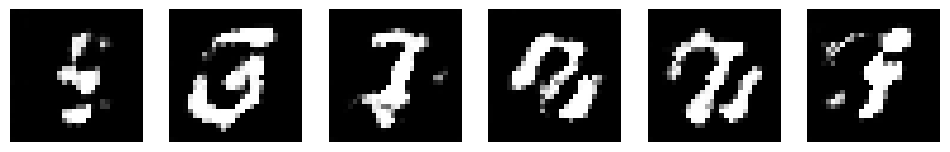

*** time now:  2023-06-01 16:35:04.106201
2/2 [==============================] - 0s 23ms/step
=== Iter: 2405 : d_loss_real: 0.744424701, d_loss_fake: 0.682450533, dcg_loss: 0.733197212 - in Epoch 3/20 - Batch 531/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 2410 : d_loss_real: 0.799294174, d_loss_fake: 0.685987830, dcg_loss: 0.710220873 - in Epoch 3/20 - Batch 536/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 2415 : d_loss_real: 0.731909633, d_loss_fake: 0.671578884, dcg_loss: 0.728640318 - in Epoch 3/20 - Batch 541/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 2420 : d_loss_real: 0.794607639, d_loss_fake: 0.727308631, dcg_loss: 0.766125321 - in Epoch 3/20 - Batch 546/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 2425 : d_loss_real: 0.740718246, d_loss_fake: 0.704544246, dcg_loss: 0.788533330 - in Epoch 3/20 - Batch 551/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 2430 : d_loss_real: 0

2/2 [==============================] - 0s 21ms/step
=== Iter: 2615 : d_loss_real: 0.648707151, d_loss_fake: 0.595197558, dcg_loss: 0.877775908 - in Epoch 3/20 - Batch 741/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2620 : d_loss_real: 0.626750648, d_loss_fake: 0.564857006, dcg_loss: 0.918319106 - in Epoch 3/20 - Batch 746/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2625 : d_loss_real: 0.617343664, d_loss_fake: 0.524110913, dcg_loss: 1.041374564 - in Epoch 3/20 - Batch 751/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2630 : d_loss_real: 0.566463113, d_loss_fake: 0.497425675, dcg_loss: 1.038155079 - in Epoch 3/20 - Batch 756/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2635 : d_loss_real: 0.502967536, d_loss_fake: 0.496945202, dcg_loss: 1.066322327 - in Epoch 3/20 - Batch 761/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2640 : d_loss_real: 0.579203308, d_loss_fake: 0.487779140, dcg_

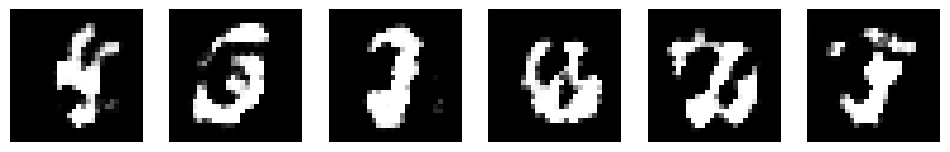

*** time now:  2023-06-01 16:36:29.604921
2/2 [==============================] - 0s 22ms/step
=== Iter: 2705 : d_loss_real: 0.621784806, d_loss_fake: 0.605426788, dcg_loss: 0.860422790 - in Epoch 3/20 - Batch 831/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2710 : d_loss_real: 0.611925721, d_loss_fake: 0.588137448, dcg_loss: 0.943400860 - in Epoch 3/20 - Batch 836/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2715 : d_loss_real: 0.622944415, d_loss_fake: 0.508284390, dcg_loss: 0.910389304 - in Epoch 3/20 - Batch 841/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2720 : d_loss_real: 0.587894559, d_loss_fake: 0.564127564, dcg_loss: 0.949894190 - in Epoch 3/20 - Batch 846/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2725 : d_loss_real: 0.516366959, d_loss_fake: 0.547303438, dcg_loss: 0.986959219 - in Epoch 3/20 - Batch 851/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 2730 : d_loss_real: 0

2/2 [==============================] - 0s 26ms/step
=== Iter: 2920 : d_loss_real: 0.510986388, d_loss_fake: 0.438150257, dcg_loss: 1.126300335 - in Epoch 4/20 - Batch 109/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 2925 : d_loss_real: 0.523078561, d_loss_fake: 0.454119265, dcg_loss: 1.016730785 - in Epoch 4/20 - Batch 114/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 2930 : d_loss_real: 0.449880272, d_loss_fake: 0.513879001, dcg_loss: 1.153601050 - in Epoch 4/20 - Batch 119/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 2935 : d_loss_real: 0.544126213, d_loss_fake: 0.565546274, dcg_loss: 1.079468489 - in Epoch 4/20 - Batch 124/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 2940 : d_loss_real: 0.575854063, d_loss_fake: 0.547581315, dcg_loss: 1.053969860 - in Epoch 4/20 - Batch 129/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 2945 : d_loss_real: 0.636123955, d_loss_fake: 0.670931756, dcg_

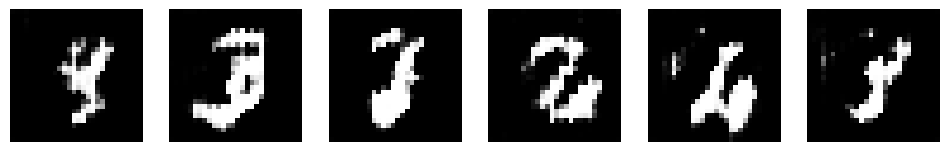

*** time now:  2023-06-01 16:38:02.586799
2/2 [==============================] - 0s 20ms/step
=== Iter: 3005 : d_loss_real: 0.579197049, d_loss_fake: 0.542015195, dcg_loss: 0.984900236 - in Epoch 4/20 - Batch 194/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 3010 : d_loss_real: 0.570350826, d_loss_fake: 0.578388810, dcg_loss: 0.912746847 - in Epoch 4/20 - Batch 199/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 3015 : d_loss_real: 0.609049499, d_loss_fake: 0.570974827, dcg_loss: 0.952271402 - in Epoch 4/20 - Batch 204/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 3020 : d_loss_real: 0.597028911, d_loss_fake: 0.625044167, dcg_loss: 0.897290945 - in Epoch 4/20 - Batch 209/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 3025 : d_loss_real: 0.593000829, d_loss_fake: 0.619720221, dcg_loss: 0.991535187 - in Epoch 4/20 - Batch 214/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 3030 : d_loss_real: 0

2/2 [==============================] - 0s 20ms/step
=== Iter: 3215 : d_loss_real: 0.516033351, d_loss_fake: 0.603424311, dcg_loss: 1.022888184 - in Epoch 4/20 - Batch 404/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 3220 : d_loss_real: 0.632773161, d_loss_fake: 0.640516639, dcg_loss: 1.001958370 - in Epoch 4/20 - Batch 409/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 3225 : d_loss_real: 0.551414251, d_loss_fake: 0.632065177, dcg_loss: 0.941549659 - in Epoch 4/20 - Batch 414/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 3230 : d_loss_real: 0.612369418, d_loss_fake: 0.607321501, dcg_loss: 0.935205936 - in Epoch 4/20 - Batch 419/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 3235 : d_loss_real: 0.576499581, d_loss_fake: 0.602369308, dcg_loss: 0.996210635 - in Epoch 4/20 - Batch 424/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 3240 : d_loss_real: 0.590921402, d_loss_fake: 0.586295962, dcg_

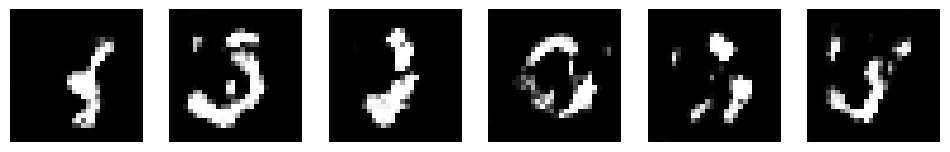

*** time now:  2023-06-01 16:39:21.916650
2/2 [==============================] - 0s 30ms/step
=== Iter: 3305 : d_loss_real: 0.699950576, d_loss_fake: 0.611985981, dcg_loss: 0.797020018 - in Epoch 4/20 - Batch 494/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 3310 : d_loss_real: 0.695821524, d_loss_fake: 0.618002653, dcg_loss: 0.783304095 - in Epoch 4/20 - Batch 499/937
2/2 [==============================] - 0s 32ms/step
=== Iter: 3315 : d_loss_real: 0.717882693, d_loss_fake: 0.577862382, dcg_loss: 0.936641455 - in Epoch 4/20 - Batch 504/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 3320 : d_loss_real: 0.633158684, d_loss_fake: 0.574229538, dcg_loss: 0.889356256 - in Epoch 4/20 - Batch 509/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 3325 : d_loss_real: 0.651460350, d_loss_fake: 0.646256208, dcg_loss: 0.898732424 - in Epoch 4/20 - Batch 514/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 3330 : d_loss_real: 0

2/2 [==============================] - 0s 25ms/step
=== Iter: 3515 : d_loss_real: 0.586710036, d_loss_fake: 0.627927899, dcg_loss: 0.955834866 - in Epoch 4/20 - Batch 704/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 3520 : d_loss_real: 0.653317332, d_loss_fake: 0.580384851, dcg_loss: 0.922918200 - in Epoch 4/20 - Batch 709/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 3525 : d_loss_real: 0.632372260, d_loss_fake: 0.615284383, dcg_loss: 0.958079815 - in Epoch 4/20 - Batch 714/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 3530 : d_loss_real: 0.638138235, d_loss_fake: 0.568485141, dcg_loss: 0.975351274 - in Epoch 4/20 - Batch 719/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 3535 : d_loss_real: 0.611169159, d_loss_fake: 0.603510797, dcg_loss: 0.981159687 - in Epoch 4/20 - Batch 724/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 3540 : d_loss_real: 0.576511264, d_loss_fake: 0.603120565, dcg_

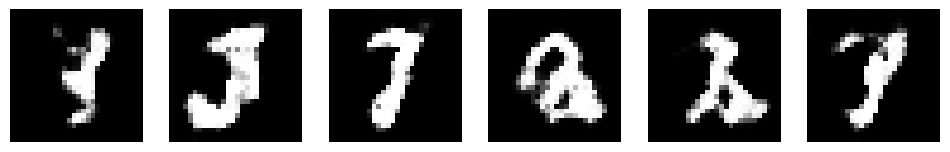

*** time now:  2023-06-01 16:40:58.379959
2/2 [==============================] - 0s 19ms/step
=== Iter: 3605 : d_loss_real: 0.548668981, d_loss_fake: 0.501038671, dcg_loss: 1.070084929 - in Epoch 4/20 - Batch 794/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 3610 : d_loss_real: 0.557311118, d_loss_fake: 0.516105771, dcg_loss: 1.107143402 - in Epoch 4/20 - Batch 799/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 3615 : d_loss_real: 0.474742144, d_loss_fake: 0.508275509, dcg_loss: 1.047338963 - in Epoch 4/20 - Batch 804/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 3620 : d_loss_real: 0.462552845, d_loss_fake: 0.506289482, dcg_loss: 1.108386040 - in Epoch 4/20 - Batch 809/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 3625 : d_loss_real: 0.502091885, d_loss_fake: 0.491214842, dcg_loss: 1.025133729 - in Epoch 4/20 - Batch 814/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 3630 : d_loss_real: 0

2/2 [==============================] - 0s 26ms/step
=== Iter: 3820 : d_loss_real: 0.698510408, d_loss_fake: 0.561276317, dcg_loss: 0.816922545 - in Epoch 5/20 - Batch 72/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 3825 : d_loss_real: 0.643005013, d_loss_fake: 0.634465039, dcg_loss: 0.863546908 - in Epoch 5/20 - Batch 77/937
2/2 [==============================] - 0s 28ms/step
=== Iter: 3830 : d_loss_real: 0.662743568, d_loss_fake: 0.634587526, dcg_loss: 0.840448499 - in Epoch 5/20 - Batch 82/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 3835 : d_loss_real: 0.655847073, d_loss_fake: 0.637897849, dcg_loss: 0.924929321 - in Epoch 5/20 - Batch 87/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 3840 : d_loss_real: 0.604623675, d_loss_fake: 0.581403732, dcg_loss: 0.925916672 - in Epoch 5/20 - Batch 92/937
2/2 [==============================] - 0s 33ms/step
=== Iter: 3845 : d_loss_real: 0.567902088, d_loss_fake: 0.605148673, dcg_loss:

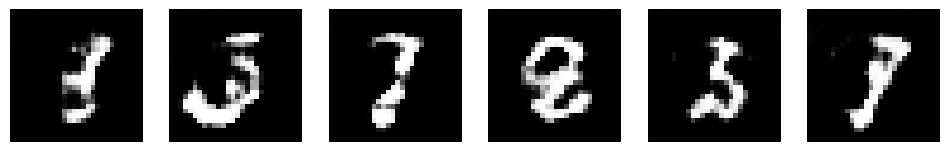

*** time now:  2023-06-01 16:42:30.316855
2/2 [==============================] - 0s 32ms/step
=== Iter: 3905 : d_loss_real: 0.570004702, d_loss_fake: 0.546506405, dcg_loss: 0.971399665 - in Epoch 5/20 - Batch 157/937
2/2 [==============================] - 0s 32ms/step
=== Iter: 3910 : d_loss_real: 0.659296155, d_loss_fake: 0.590797484, dcg_loss: 0.958572626 - in Epoch 5/20 - Batch 162/937
2/2 [==============================] - 0s 31ms/step
=== Iter: 3915 : d_loss_real: 0.518076897, d_loss_fake: 0.728140891, dcg_loss: 0.908018649 - in Epoch 5/20 - Batch 167/937
2/2 [==============================] - 0s 31ms/step
=== Iter: 3920 : d_loss_real: 0.647386551, d_loss_fake: 0.631913900, dcg_loss: 0.865680099 - in Epoch 5/20 - Batch 172/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 3925 : d_loss_real: 0.601228714, d_loss_fake: 0.626375377, dcg_loss: 0.858730972 - in Epoch 5/20 - Batch 177/937
2/2 [==============================] - 0s 28ms/step
=== Iter: 3930 : d_loss_real: 0

2/2 [==============================] - 0s 23ms/step
=== Iter: 4115 : d_loss_real: 0.491634279, d_loss_fake: 0.498000711, dcg_loss: 1.014058590 - in Epoch 5/20 - Batch 367/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 4120 : d_loss_real: 0.486740172, d_loss_fake: 0.576399207, dcg_loss: 1.106718063 - in Epoch 5/20 - Batch 372/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4125 : d_loss_real: 0.451254487, d_loss_fake: 0.464726925, dcg_loss: 0.947650313 - in Epoch 5/20 - Batch 377/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4130 : d_loss_real: 0.648940206, d_loss_fake: 0.540897429, dcg_loss: 1.164990902 - in Epoch 5/20 - Batch 382/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4135 : d_loss_real: 0.552258611, d_loss_fake: 0.523188949, dcg_loss: 1.033675790 - in Epoch 5/20 - Batch 387/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4140 : d_loss_real: 0.500826359, d_loss_fake: 0.408666462, dcg_

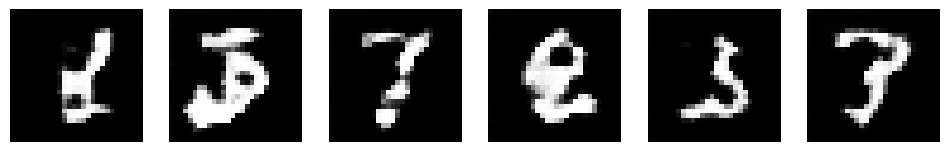

*** time now:  2023-06-01 16:44:00.397816
2/2 [==============================] - 0s 28ms/step
=== Iter: 4205 : d_loss_real: 0.539431572, d_loss_fake: 0.588979483, dcg_loss: 0.986369729 - in Epoch 5/20 - Batch 457/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 4210 : d_loss_real: 0.537531257, d_loss_fake: 0.629510939, dcg_loss: 1.018742800 - in Epoch 5/20 - Batch 462/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4215 : d_loss_real: 0.561056018, d_loss_fake: 0.568800449, dcg_loss: 1.045823812 - in Epoch 5/20 - Batch 467/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4220 : d_loss_real: 0.562743902, d_loss_fake: 0.544823408, dcg_loss: 1.118739128 - in Epoch 5/20 - Batch 472/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 4225 : d_loss_real: 0.592186093, d_loss_fake: 0.558533132, dcg_loss: 1.034339428 - in Epoch 5/20 - Batch 477/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 4230 : d_loss_real: 0

2/2 [==============================] - 0s 23ms/step
=== Iter: 4415 : d_loss_real: 0.564180017, d_loss_fake: 0.522946715, dcg_loss: 1.483734608 - in Epoch 5/20 - Batch 667/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4420 : d_loss_real: 0.492134809, d_loss_fake: 0.487054139, dcg_loss: 1.381204367 - in Epoch 5/20 - Batch 672/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4425 : d_loss_real: 0.512912214, d_loss_fake: 0.639658809, dcg_loss: 1.007908583 - in Epoch 5/20 - Batch 677/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4430 : d_loss_real: 0.693712771, d_loss_fake: 0.728203952, dcg_loss: 1.035927415 - in Epoch 5/20 - Batch 682/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4435 : d_loss_real: 0.754981279, d_loss_fake: 0.594065428, dcg_loss: 1.108203530 - in Epoch 5/20 - Batch 687/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4440 : d_loss_real: 0.670304537, d_loss_fake: 0.512716889, dcg_

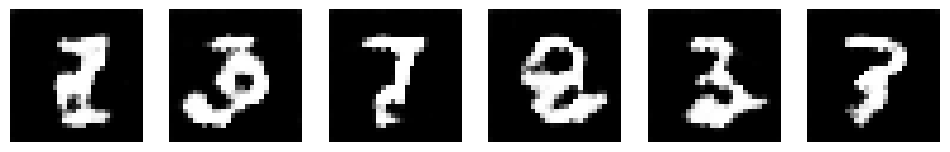

*** time now:  2023-06-01 16:45:32.393137
2/2 [==============================] - 0s 21ms/step
=== Iter: 4505 : d_loss_real: 0.513154685, d_loss_fake: 0.434612393, dcg_loss: 1.366085410 - in Epoch 5/20 - Batch 757/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4510 : d_loss_real: 0.454004526, d_loss_fake: 0.428946704, dcg_loss: 1.115660429 - in Epoch 5/20 - Batch 762/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 4515 : d_loss_real: 0.577293515, d_loss_fake: 0.459549308, dcg_loss: 1.206381798 - in Epoch 5/20 - Batch 767/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 4520 : d_loss_real: 0.489126176, d_loss_fake: 0.489059508, dcg_loss: 1.198028803 - in Epoch 5/20 - Batch 772/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 4525 : d_loss_real: 0.572526813, d_loss_fake: 0.470738411, dcg_loss: 1.218088269 - in Epoch 5/20 - Batch 777/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 4530 : d_loss_real: 0

=== Iter: 4715 : d_loss_real: 0.605756402, d_loss_fake: 0.588529527, dcg_loss: 1.210446954 - in Epoch 6/20 - Batch 30/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 4720 : d_loss_real: 0.479126662, d_loss_fake: 0.469482899, dcg_loss: 1.113013506 - in Epoch 6/20 - Batch 35/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 4725 : d_loss_real: 0.503698885, d_loss_fake: 0.433591008, dcg_loss: 1.354915619 - in Epoch 6/20 - Batch 40/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 4730 : d_loss_real: 0.516489267, d_loss_fake: 0.420780718, dcg_loss: 1.295748949 - in Epoch 6/20 - Batch 45/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4735 : d_loss_real: 0.557934761, d_loss_fake: 0.482708395, dcg_loss: 1.192126036 - in Epoch 6/20 - Batch 50/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4740 : d_loss_real: 0.490812480, d_loss_fake: 0.530439317, dcg_loss: 1.011702776 - in Epoch 6/20 - Batch 55/937
2/2 [===

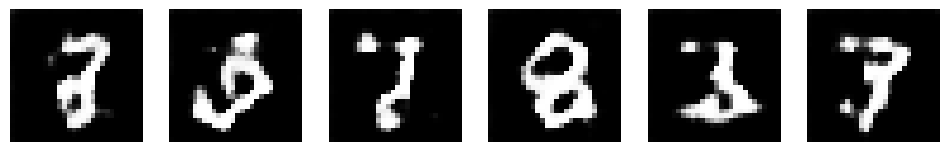

*** time now:  2023-06-01 16:46:59.807282
2/2 [==============================] - 0s 24ms/step
=== Iter: 4805 : d_loss_real: 0.463473618, d_loss_fake: 0.584547579, dcg_loss: 1.009766579 - in Epoch 6/20 - Batch 120/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 4810 : d_loss_real: 0.549529314, d_loss_fake: 0.484873354, dcg_loss: 0.998848319 - in Epoch 6/20 - Batch 125/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4815 : d_loss_real: 0.558291674, d_loss_fake: 0.529113591, dcg_loss: 1.143007278 - in Epoch 6/20 - Batch 130/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4820 : d_loss_real: 0.482201457, d_loss_fake: 0.596001804, dcg_loss: 1.168403625 - in Epoch 6/20 - Batch 135/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 4825 : d_loss_real: 0.621286869, d_loss_fake: 0.592520177, dcg_loss: 1.101362705 - in Epoch 6/20 - Batch 140/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 4830 : d_loss_real: 0

2/2 [==============================] - 0s 22ms/step
=== Iter: 5015 : d_loss_real: 0.644761682, d_loss_fake: 0.532175422, dcg_loss: 0.995073318 - in Epoch 6/20 - Batch 330/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 5020 : d_loss_real: 0.619460464, d_loss_fake: 0.616656363, dcg_loss: 1.015356779 - in Epoch 6/20 - Batch 335/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 5025 : d_loss_real: 0.509774089, d_loss_fake: 0.660093546, dcg_loss: 1.081078887 - in Epoch 6/20 - Batch 340/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 5030 : d_loss_real: 0.630048990, d_loss_fake: 0.469063222, dcg_loss: 0.992375731 - in Epoch 6/20 - Batch 345/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 5035 : d_loss_real: 0.600559056, d_loss_fake: 0.642226219, dcg_loss: 0.950913131 - in Epoch 6/20 - Batch 350/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 5040 : d_loss_real: 0.514325261, d_loss_fake: 0.542020798, dcg_

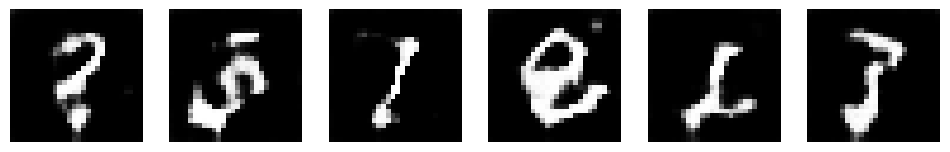

*** time now:  2023-06-01 16:48:24.993434
2/2 [==============================] - 0s 20ms/step
=== Iter: 5105 : d_loss_real: 0.578500152, d_loss_fake: 0.749812484, dcg_loss: 0.992058039 - in Epoch 6/20 - Batch 420/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 5110 : d_loss_real: 0.699939787, d_loss_fake: 0.631909609, dcg_loss: 0.974001884 - in Epoch 6/20 - Batch 425/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 5115 : d_loss_real: 0.572836280, d_loss_fake: 0.614482701, dcg_loss: 1.011182427 - in Epoch 6/20 - Batch 430/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 5120 : d_loss_real: 0.678138971, d_loss_fake: 0.736519694, dcg_loss: 0.863831401 - in Epoch 6/20 - Batch 435/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 5125 : d_loss_real: 0.804663777, d_loss_fake: 0.621929586, dcg_loss: 1.019594193 - in Epoch 6/20 - Batch 440/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 5130 : d_loss_real: 0

2/2 [==============================] - 0s 22ms/step
=== Iter: 5315 : d_loss_real: 0.532951593, d_loss_fake: 0.553779602, dcg_loss: 1.016128182 - in Epoch 6/20 - Batch 630/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 5320 : d_loss_real: 0.619813204, d_loss_fake: 0.595853806, dcg_loss: 1.075672507 - in Epoch 6/20 - Batch 635/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 5325 : d_loss_real: 0.672255278, d_loss_fake: 0.545830071, dcg_loss: 1.074212432 - in Epoch 6/20 - Batch 640/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 5330 : d_loss_real: 0.647112608, d_loss_fake: 0.549825788, dcg_loss: 0.933674693 - in Epoch 6/20 - Batch 645/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 5335 : d_loss_real: 0.531379700, d_loss_fake: 0.629812121, dcg_loss: 0.991995752 - in Epoch 6/20 - Batch 650/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 5340 : d_loss_real: 0.527178168, d_loss_fake: 0.651340067, dcg_

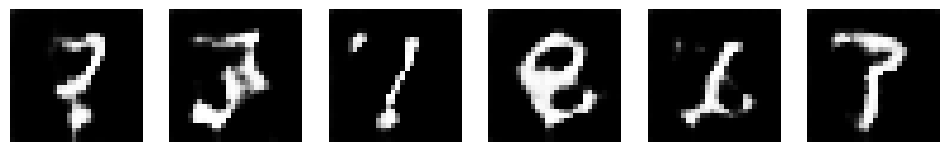

*** time now:  2023-06-01 16:49:54.297143
2/2 [==============================] - 0s 26ms/step
=== Iter: 5405 : d_loss_real: 0.605575621, d_loss_fake: 0.682223797, dcg_loss: 0.903601408 - in Epoch 6/20 - Batch 720/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 5410 : d_loss_real: 0.594826698, d_loss_fake: 0.581060827, dcg_loss: 0.937063754 - in Epoch 6/20 - Batch 725/937
2/2 [==============================] - 0s 33ms/step
=== Iter: 5415 : d_loss_real: 0.768365264, d_loss_fake: 0.612715244, dcg_loss: 0.874930024 - in Epoch 6/20 - Batch 730/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 5420 : d_loss_real: 0.641349316, d_loss_fake: 0.718531013, dcg_loss: 0.838883877 - in Epoch 6/20 - Batch 735/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 5425 : d_loss_real: 0.715966642, d_loss_fake: 0.615822732, dcg_loss: 0.938432276 - in Epoch 6/20 - Batch 740/937
2/2 [==============================] - 0s 35ms/step
=== Iter: 5430 : d_loss_real: 0

2/2 [==============================] - 0s 19ms/step
=== Iter: 5615 : d_loss_real: 0.623553395, d_loss_fake: 0.558846951, dcg_loss: 1.011164188 - in Epoch 6/20 - Batch 930/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 5620 : d_loss_real: 0.609849811, d_loss_fake: 0.526873708, dcg_loss: 1.032468081 - in Epoch 6/20 - Batch 935/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 5625 : d_loss_real: 0.624605417, d_loss_fake: 0.567836642, dcg_loss: 0.989908397 - in Epoch 7/20 - Batch 3/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5630 : d_loss_real: 0.639124513, d_loss_fake: 0.605952799, dcg_loss: 1.044113278 - in Epoch 7/20 - Batch 8/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 5635 : d_loss_real: 0.622202516, d_loss_fake: 0.615867496, dcg_loss: 0.967890799 - in Epoch 7/20 - Batch 13/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5640 : d_loss_real: 0.605639458, d_loss_fake: 0.655867279, dcg_loss:

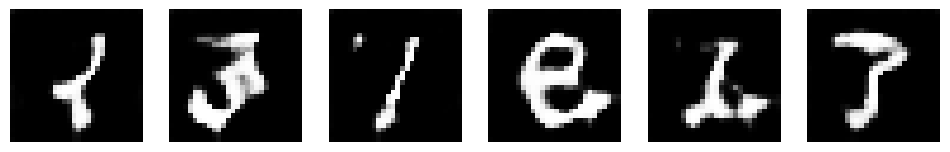

*** time now:  2023-06-01 16:51:32.284443
2/2 [==============================] - 0s 18ms/step
=== Iter: 5705 : d_loss_real: 0.584847689, d_loss_fake: 0.682168901, dcg_loss: 0.852296591 - in Epoch 7/20 - Batch 83/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5710 : d_loss_real: 0.630951881, d_loss_fake: 0.698431969, dcg_loss: 0.901324272 - in Epoch 7/20 - Batch 88/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5715 : d_loss_real: 0.648088932, d_loss_fake: 0.676856458, dcg_loss: 0.881678522 - in Epoch 7/20 - Batch 93/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 5720 : d_loss_real: 0.572271705, d_loss_fake: 0.725918889, dcg_loss: 0.882575512 - in Epoch 7/20 - Batch 98/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 5725 : d_loss_real: 0.637506127, d_loss_fake: 0.649775743, dcg_loss: 0.975311160 - in Epoch 7/20 - Batch 103/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 5730 : d_loss_real: 0.647

2/2 [==============================] - 0s 20ms/step
=== Iter: 5915 : d_loss_real: 0.683107257, d_loss_fake: 0.620190501, dcg_loss: 0.825907826 - in Epoch 7/20 - Batch 293/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 5920 : d_loss_real: 0.638711989, d_loss_fake: 0.582380891, dcg_loss: 0.834059596 - in Epoch 7/20 - Batch 298/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5925 : d_loss_real: 0.636561215, d_loss_fake: 0.679957032, dcg_loss: 0.741066933 - in Epoch 7/20 - Batch 303/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5930 : d_loss_real: 0.619396210, d_loss_fake: 0.696459174, dcg_loss: 0.871156991 - in Epoch 7/20 - Batch 308/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5935 : d_loss_real: 0.609317183, d_loss_fake: 0.658019781, dcg_loss: 0.870980620 - in Epoch 7/20 - Batch 313/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 5940 : d_loss_real: 0.665041804, d_loss_fake: 0.677158356, dcg_

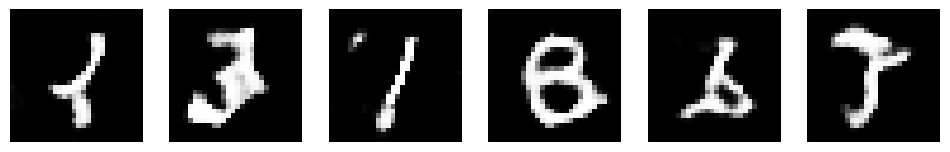

*** time now:  2023-06-01 16:52:46.144096
2/2 [==============================] - 0s 20ms/step
=== Iter: 6005 : d_loss_real: 0.578175724, d_loss_fake: 0.637601912, dcg_loss: 0.913667738 - in Epoch 7/20 - Batch 383/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 6010 : d_loss_real: 0.639653087, d_loss_fake: 0.548179865, dcg_loss: 0.849016666 - in Epoch 7/20 - Batch 388/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 6015 : d_loss_real: 0.593232393, d_loss_fake: 0.668755651, dcg_loss: 0.857669055 - in Epoch 7/20 - Batch 393/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 6020 : d_loss_real: 0.615524292, d_loss_fake: 0.662371933, dcg_loss: 0.841500342 - in Epoch 7/20 - Batch 398/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 6025 : d_loss_real: 0.659755290, d_loss_fake: 0.605645180, dcg_loss: 0.842926145 - in Epoch 7/20 - Batch 403/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 6030 : d_loss_real: 0

2/2 [==============================] - 0s 20ms/step
=== Iter: 6215 : d_loss_real: 0.599712729, d_loss_fake: 0.657330036, dcg_loss: 0.865274727 - in Epoch 7/20 - Batch 593/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6220 : d_loss_real: 0.683264375, d_loss_fake: 0.680302739, dcg_loss: 0.823636949 - in Epoch 7/20 - Batch 598/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 6225 : d_loss_real: 0.669728518, d_loss_fake: 0.713011742, dcg_loss: 0.790005565 - in Epoch 7/20 - Batch 603/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 6230 : d_loss_real: 0.594391048, d_loss_fake: 0.720211625, dcg_loss: 0.867489457 - in Epoch 7/20 - Batch 608/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6235 : d_loss_real: 0.745636642, d_loss_fake: 0.608257532, dcg_loss: 0.844769061 - in Epoch 7/20 - Batch 613/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 6240 : d_loss_real: 0.595636308, d_loss_fake: 0.733748734, dcg_

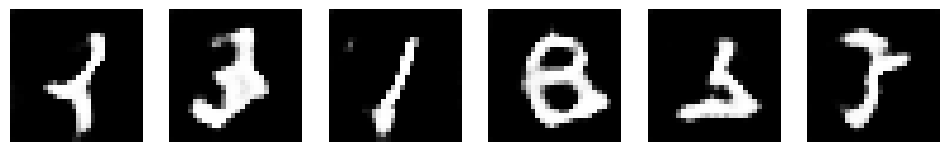

*** time now:  2023-06-01 16:54:05.193987
2/2 [==============================] - 0s 21ms/step
=== Iter: 6305 : d_loss_real: 0.647294760, d_loss_fake: 0.654253125, dcg_loss: 0.833469033 - in Epoch 7/20 - Batch 683/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6310 : d_loss_real: 0.658937693, d_loss_fake: 0.658801973, dcg_loss: 0.796404719 - in Epoch 7/20 - Batch 688/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6315 : d_loss_real: 0.636310339, d_loss_fake: 0.598417878, dcg_loss: 0.862317920 - in Epoch 7/20 - Batch 693/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6320 : d_loss_real: 0.638191342, d_loss_fake: 0.733677328, dcg_loss: 0.815848827 - in Epoch 7/20 - Batch 698/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 6325 : d_loss_real: 0.634151578, d_loss_fake: 0.705469608, dcg_loss: 0.758761466 - in Epoch 7/20 - Batch 703/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 6330 : d_loss_real: 0

2/2 [==============================] - 0s 69ms/step
=== Iter: 6515 : d_loss_real: 0.533143640, d_loss_fake: 0.627586186, dcg_loss: 0.889991462 - in Epoch 7/20 - Batch 893/937
2/2 [==============================] - 0s 66ms/step
=== Iter: 6520 : d_loss_real: 0.592156172, d_loss_fake: 0.778344810, dcg_loss: 0.900222957 - in Epoch 7/20 - Batch 898/937
2/2 [==============================] - 0s 69ms/step
=== Iter: 6525 : d_loss_real: 0.674181104, d_loss_fake: 0.744719923, dcg_loss: 0.790608764 - in Epoch 7/20 - Batch 903/937
2/2 [==============================] - 0s 69ms/step
=== Iter: 6530 : d_loss_real: 0.643894374, d_loss_fake: 0.726406753, dcg_loss: 0.796701789 - in Epoch 7/20 - Batch 908/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 6535 : d_loss_real: 0.570739329, d_loss_fake: 0.574121714, dcg_loss: 0.852665544 - in Epoch 7/20 - Batch 913/937
2/2 [==============================] - 0s 46ms/step
=== Iter: 6540 : d_loss_real: 0.596916854, d_loss_fake: 0.637859166, dcg_

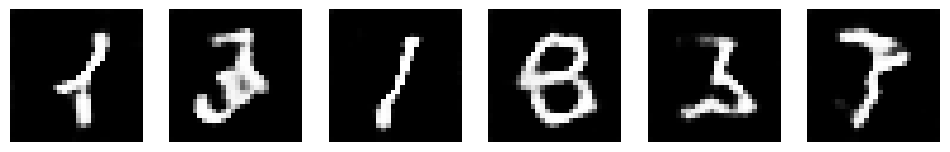

*** time now:  2023-06-01 17:03:41.327271
2/2 [==============================] - 0s 86ms/step
=== Iter: 6605 : d_loss_real: 0.724485099, d_loss_fake: 0.704519868, dcg_loss: 0.876474321 - in Epoch 8/20 - Batch 46/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 6610 : d_loss_real: 0.568472981, d_loss_fake: 0.866902113, dcg_loss: 0.699186087 - in Epoch 8/20 - Batch 51/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 6615 : d_loss_real: 0.662839890, d_loss_fake: 0.733264506, dcg_loss: 0.743163466 - in Epoch 8/20 - Batch 56/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 6620 : d_loss_real: 0.684919775, d_loss_fake: 0.730723798, dcg_loss: 0.691302717 - in Epoch 8/20 - Batch 61/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6625 : d_loss_real: 0.583554149, d_loss_fake: 0.767009437, dcg_loss: 0.794631362 - in Epoch 8/20 - Batch 66/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 6630 : d_loss_real: 0.5638

2/2 [==============================] - 0s 21ms/step
=== Iter: 6815 : d_loss_real: 0.609733343, d_loss_fake: 0.686167717, dcg_loss: 0.733272433 - in Epoch 8/20 - Batch 256/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 6820 : d_loss_real: 0.606668949, d_loss_fake: 0.662668109, dcg_loss: 0.879412413 - in Epoch 8/20 - Batch 261/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6825 : d_loss_real: 0.664335012, d_loss_fake: 0.696505308, dcg_loss: 0.770560145 - in Epoch 8/20 - Batch 266/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6830 : d_loss_real: 0.595552146, d_loss_fake: 0.695106030, dcg_loss: 0.867767751 - in Epoch 8/20 - Batch 271/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 6835 : d_loss_real: 0.674211025, d_loss_fake: 0.661380470, dcg_loss: 0.785102129 - in Epoch 8/20 - Batch 276/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6840 : d_loss_real: 0.606020331, d_loss_fake: 0.598648131, dcg_

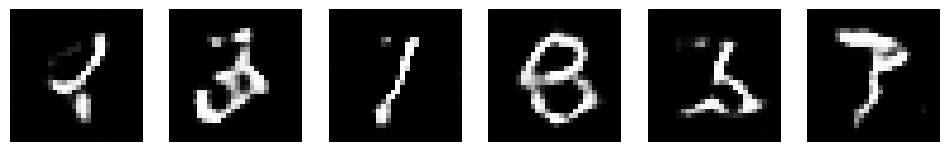

*** time now:  2023-06-01 17:05:07.713722
2/2 [==============================] - 0s 22ms/step
=== Iter: 6905 : d_loss_real: 0.553522885, d_loss_fake: 0.553022444, dcg_loss: 1.008940697 - in Epoch 8/20 - Batch 346/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6910 : d_loss_real: 0.622498214, d_loss_fake: 0.580596864, dcg_loss: 0.915508032 - in Epoch 8/20 - Batch 351/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 6915 : d_loss_real: 0.714219213, d_loss_fake: 0.649369299, dcg_loss: 0.912205160 - in Epoch 8/20 - Batch 356/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6920 : d_loss_real: 0.541404545, d_loss_fake: 0.708816290, dcg_loss: 0.671068251 - in Epoch 8/20 - Batch 361/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 6925 : d_loss_real: 0.592378855, d_loss_fake: 0.696310997, dcg_loss: 0.770853400 - in Epoch 8/20 - Batch 366/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 6930 : d_loss_real: 0

2/2 [==============================] - 0s 21ms/step
=== Iter: 7115 : d_loss_real: 0.729180098, d_loss_fake: 0.564089179, dcg_loss: 1.024770498 - in Epoch 8/20 - Batch 556/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7120 : d_loss_real: 0.644276321, d_loss_fake: 0.538127661, dcg_loss: 0.985834122 - in Epoch 8/20 - Batch 561/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7125 : d_loss_real: 0.655470490, d_loss_fake: 0.542614400, dcg_loss: 1.018116713 - in Epoch 8/20 - Batch 566/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7130 : d_loss_real: 0.633837700, d_loss_fake: 0.627883732, dcg_loss: 0.878594637 - in Epoch 8/20 - Batch 571/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7135 : d_loss_real: 0.553464413, d_loss_fake: 0.701561689, dcg_loss: 0.803040385 - in Epoch 8/20 - Batch 576/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7140 : d_loss_real: 0.659604907, d_loss_fake: 0.636300802, dcg_

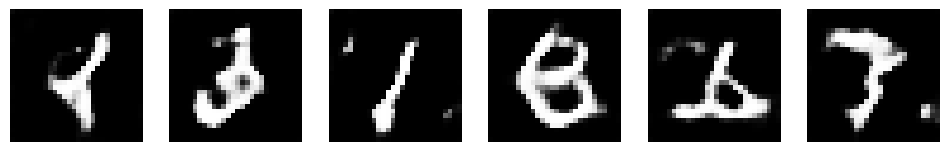

*** time now:  2023-06-01 17:06:35.595581
2/2 [==============================] - 0s 21ms/step
=== Iter: 7205 : d_loss_real: 0.620471776, d_loss_fake: 0.681743979, dcg_loss: 0.711871386 - in Epoch 8/20 - Batch 646/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 7210 : d_loss_real: 0.746516109, d_loss_fake: 0.740605474, dcg_loss: 0.752277911 - in Epoch 8/20 - Batch 651/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7215 : d_loss_real: 0.698906541, d_loss_fake: 0.661839485, dcg_loss: 0.801174760 - in Epoch 8/20 - Batch 656/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 7220 : d_loss_real: 0.764520109, d_loss_fake: 0.612783074, dcg_loss: 0.896792531 - in Epoch 8/20 - Batch 661/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7225 : d_loss_real: 0.669337988, d_loss_fake: 0.648284793, dcg_loss: 0.928553879 - in Epoch 8/20 - Batch 666/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7230 : d_loss_real: 0

2/2 [==============================] - 0s 21ms/step
=== Iter: 7415 : d_loss_real: 0.551408947, d_loss_fake: 0.577833295, dcg_loss: 0.911432862 - in Epoch 8/20 - Batch 856/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7420 : d_loss_real: 0.580110669, d_loss_fake: 0.640469015, dcg_loss: 0.979197204 - in Epoch 8/20 - Batch 861/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 7425 : d_loss_real: 0.757347226, d_loss_fake: 0.619868815, dcg_loss: 0.833820105 - in Epoch 8/20 - Batch 866/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7430 : d_loss_real: 0.681933939, d_loss_fake: 0.681530476, dcg_loss: 0.728500485 - in Epoch 8/20 - Batch 871/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 7435 : d_loss_real: 0.754108787, d_loss_fake: 0.686480105, dcg_loss: 0.804663181 - in Epoch 8/20 - Batch 876/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7440 : d_loss_real: 0.677498460, d_loss_fake: 0.626449347, dcg_

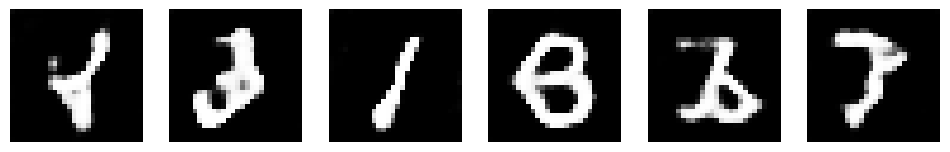

*** time now:  2023-06-01 17:08:00.278739
2/2 [==============================] - 0s 24ms/step
=== Iter: 7505 : d_loss_real: 0.662498355, d_loss_fake: 0.629637361, dcg_loss: 0.776733994 - in Epoch 9/20 - Batch 9/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7510 : d_loss_real: 0.616390228, d_loss_fake: 0.649810612, dcg_loss: 0.758372784 - in Epoch 9/20 - Batch 14/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7515 : d_loss_real: 0.573713779, d_loss_fake: 0.647718549, dcg_loss: 0.939321816 - in Epoch 9/20 - Batch 19/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7520 : d_loss_real: 0.637534082, d_loss_fake: 0.592947483, dcg_loss: 0.895601749 - in Epoch 9/20 - Batch 24/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7525 : d_loss_real: 0.597638249, d_loss_fake: 0.577657580, dcg_loss: 0.919031024 - in Epoch 9/20 - Batch 29/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7530 : d_loss_real: 0.65597

2/2 [==============================] - 0s 21ms/step
=== Iter: 7715 : d_loss_real: 0.671451330, d_loss_fake: 0.678977787, dcg_loss: 0.788092911 - in Epoch 9/20 - Batch 219/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7720 : d_loss_real: 0.643394411, d_loss_fake: 0.635473132, dcg_loss: 0.755995870 - in Epoch 9/20 - Batch 224/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 7725 : d_loss_real: 0.625901699, d_loss_fake: 0.697909534, dcg_loss: 0.748114467 - in Epoch 9/20 - Batch 229/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7730 : d_loss_real: 0.620893717, d_loss_fake: 0.714956164, dcg_loss: 0.742591441 - in Epoch 9/20 - Batch 234/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7735 : d_loss_real: 0.625921488, d_loss_fake: 0.659212470, dcg_loss: 0.811429799 - in Epoch 9/20 - Batch 239/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7740 : d_loss_real: 0.599248528, d_loss_fake: 0.636043549, dcg_

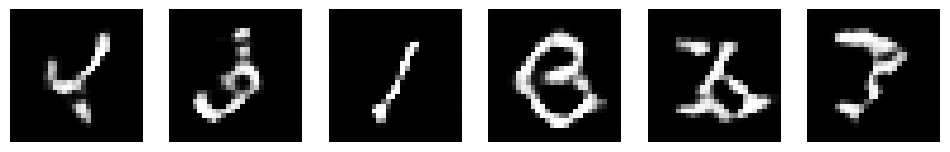

*** time now:  2023-06-01 17:09:23.083987
2/2 [==============================] - 0s 21ms/step
=== Iter: 7805 : d_loss_real: 0.551858008, d_loss_fake: 0.568698049, dcg_loss: 1.010983944 - in Epoch 9/20 - Batch 309/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7810 : d_loss_real: 0.584036946, d_loss_fake: 0.547297239, dcg_loss: 1.009013414 - in Epoch 9/20 - Batch 314/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7815 : d_loss_real: 0.548422813, d_loss_fake: 0.639551997, dcg_loss: 0.920320153 - in Epoch 9/20 - Batch 319/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7820 : d_loss_real: 0.626550078, d_loss_fake: 0.600188255, dcg_loss: 0.871262908 - in Epoch 9/20 - Batch 324/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 7825 : d_loss_real: 0.632946551, d_loss_fake: 0.686641932, dcg_loss: 0.838439047 - in Epoch 9/20 - Batch 329/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 7830 : d_loss_real: 0

2/2 [==============================] - 0s 21ms/step
=== Iter: 8015 : d_loss_real: 0.743998766, d_loss_fake: 0.659113765, dcg_loss: 0.881341100 - in Epoch 9/20 - Batch 519/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8020 : d_loss_real: 0.757581115, d_loss_fake: 0.584574819, dcg_loss: 0.868757606 - in Epoch 9/20 - Batch 524/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8025 : d_loss_real: 0.648003817, d_loss_fake: 0.567404091, dcg_loss: 0.894616961 - in Epoch 9/20 - Batch 529/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 8030 : d_loss_real: 0.606047750, d_loss_fake: 0.525677681, dcg_loss: 0.991145968 - in Epoch 9/20 - Batch 534/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8035 : d_loss_real: 0.605034411, d_loss_fake: 0.520789027, dcg_loss: 1.005630612 - in Epoch 9/20 - Batch 539/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8040 : d_loss_real: 0.575895786, d_loss_fake: 0.570942044, dcg_

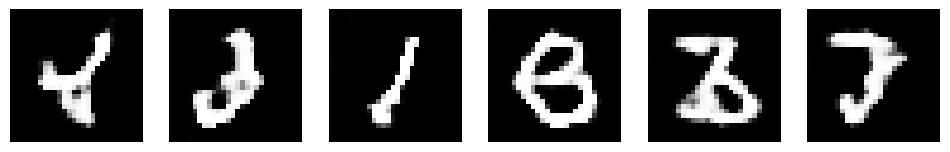

*** time now:  2023-06-01 17:10:47.008745
2/2 [==============================] - 0s 23ms/step
=== Iter: 8105 : d_loss_real: 0.613226414, d_loss_fake: 0.595011055, dcg_loss: 0.854977369 - in Epoch 9/20 - Batch 609/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8110 : d_loss_real: 0.638896525, d_loss_fake: 0.621182561, dcg_loss: 0.856184363 - in Epoch 9/20 - Batch 614/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8115 : d_loss_real: 0.643311501, d_loss_fake: 0.649200201, dcg_loss: 0.850962043 - in Epoch 9/20 - Batch 619/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 8120 : d_loss_real: 0.688872516, d_loss_fake: 0.649193168, dcg_loss: 0.805653095 - in Epoch 9/20 - Batch 624/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8125 : d_loss_real: 0.645385623, d_loss_fake: 0.641257882, dcg_loss: 0.749406815 - in Epoch 9/20 - Batch 629/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8130 : d_loss_real: 0

2/2 [==============================] - 0s 22ms/step
=== Iter: 8315 : d_loss_real: 0.709268689, d_loss_fake: 0.637329221, dcg_loss: 0.880782723 - in Epoch 9/20 - Batch 819/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8320 : d_loss_real: 0.604903460, d_loss_fake: 0.602155447, dcg_loss: 0.785506725 - in Epoch 9/20 - Batch 824/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8325 : d_loss_real: 0.619647920, d_loss_fake: 0.600517929, dcg_loss: 0.835756779 - in Epoch 9/20 - Batch 829/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8330 : d_loss_real: 0.622478366, d_loss_fake: 0.627520084, dcg_loss: 0.970789552 - in Epoch 9/20 - Batch 834/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8335 : d_loss_real: 0.557962656, d_loss_fake: 0.507914186, dcg_loss: 0.974786222 - in Epoch 9/20 - Batch 839/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8340 : d_loss_real: 0.632489622, d_loss_fake: 0.551800013, dcg_

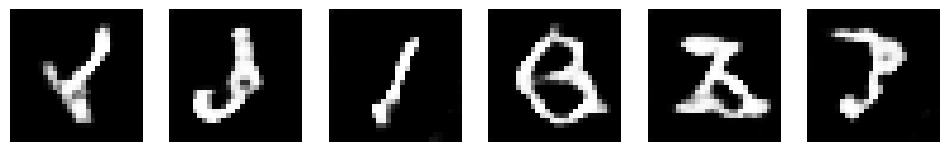

*** time now:  2023-06-01 17:12:11.453159
2/2 [==============================] - 0s 24ms/step
=== Iter: 8405 : d_loss_real: 0.643544555, d_loss_fake: 0.709850192, dcg_loss: 0.681958079 - in Epoch 9/20 - Batch 909/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8410 : d_loss_real: 0.661993742, d_loss_fake: 0.715159178, dcg_loss: 0.687516212 - in Epoch 9/20 - Batch 914/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8415 : d_loss_real: 0.748191714, d_loss_fake: 0.735935688, dcg_loss: 0.771166861 - in Epoch 9/20 - Batch 919/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8420 : d_loss_real: 0.658449650, d_loss_fake: 0.724475622, dcg_loss: 0.784753859 - in Epoch 9/20 - Batch 924/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8425 : d_loss_real: 0.641949058, d_loss_fake: 0.677069306, dcg_loss: 0.754058599 - in Epoch 9/20 - Batch 929/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8430 : d_loss_real: 0

2/2 [==============================] - 0s 20ms/step
=== Iter: 8615 : d_loss_real: 0.694009364, d_loss_fake: 0.627406120, dcg_loss: 0.917402506 - in Epoch 10/20 - Batch 182/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8620 : d_loss_real: 0.641568363, d_loss_fake: 0.602804124, dcg_loss: 0.852326512 - in Epoch 10/20 - Batch 187/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8625 : d_loss_real: 0.632235110, d_loss_fake: 0.725121021, dcg_loss: 0.737823069 - in Epoch 10/20 - Batch 192/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8630 : d_loss_real: 0.659921646, d_loss_fake: 0.667678714, dcg_loss: 0.816030979 - in Epoch 10/20 - Batch 197/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8635 : d_loss_real: 0.656291783, d_loss_fake: 0.685994565, dcg_loss: 0.904053569 - in Epoch 10/20 - Batch 202/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8640 : d_loss_real: 0.643607497, d_loss_fake: 0.712466002,

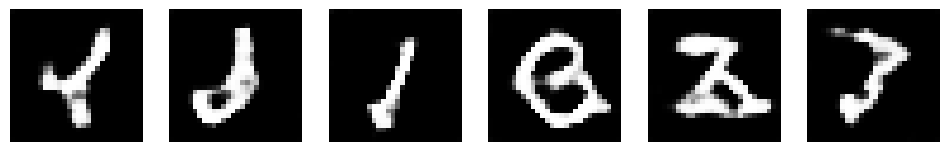

*** time now:  2023-06-01 17:13:37.318723
2/2 [==============================] - 0s 23ms/step
=== Iter: 8705 : d_loss_real: 0.750411630, d_loss_fake: 0.645962954, dcg_loss: 0.833136261 - in Epoch 10/20 - Batch 272/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8710 : d_loss_real: 0.652180135, d_loss_fake: 0.617771447, dcg_loss: 0.769209981 - in Epoch 10/20 - Batch 277/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8715 : d_loss_real: 0.666509807, d_loss_fake: 0.655464411, dcg_loss: 0.875665545 - in Epoch 10/20 - Batch 282/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 8720 : d_loss_real: 0.690829754, d_loss_fake: 0.613350213, dcg_loss: 0.836067736 - in Epoch 10/20 - Batch 287/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8725 : d_loss_real: 0.649667501, d_loss_fake: 0.574935615, dcg_loss: 0.835483193 - in Epoch 10/20 - Batch 292/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8730 : d_loss_re

2/2 [==============================] - 0s 22ms/step
=== Iter: 8915 : d_loss_real: 0.586016655, d_loss_fake: 0.594363689, dcg_loss: 0.889132857 - in Epoch 10/20 - Batch 482/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8920 : d_loss_real: 0.546419322, d_loss_fake: 0.639508307, dcg_loss: 0.907980680 - in Epoch 10/20 - Batch 487/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 8925 : d_loss_real: 0.644524097, d_loss_fake: 0.663509011, dcg_loss: 0.848339260 - in Epoch 10/20 - Batch 492/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 8930 : d_loss_real: 0.583857536, d_loss_fake: 0.692350507, dcg_loss: 0.849909782 - in Epoch 10/20 - Batch 497/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 8935 : d_loss_real: 0.646661878, d_loss_fake: 0.625946462, dcg_loss: 0.808361292 - in Epoch 10/20 - Batch 502/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 8940 : d_loss_real: 0.699318290, d_loss_fake: 0.670331955,

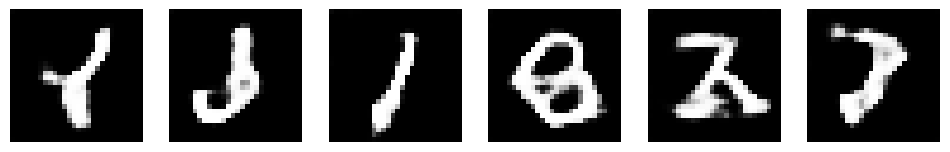

*** time now:  2023-06-01 17:15:00.291508
2/2 [==============================] - 0s 22ms/step
=== Iter: 9005 : d_loss_real: 0.675026059, d_loss_fake: 0.630260050, dcg_loss: 0.798763514 - in Epoch 10/20 - Batch 572/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 9010 : d_loss_real: 0.658889234, d_loss_fake: 0.601535797, dcg_loss: 0.827812552 - in Epoch 10/20 - Batch 577/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 9015 : d_loss_real: 0.589581490, d_loss_fake: 0.626406550, dcg_loss: 0.873585284 - in Epoch 10/20 - Batch 582/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9020 : d_loss_real: 0.565185070, d_loss_fake: 0.630202830, dcg_loss: 0.853795826 - in Epoch 10/20 - Batch 587/937
2/2 [==============================] - 0s 28ms/step
=== Iter: 9025 : d_loss_real: 0.622172713, d_loss_fake: 0.605350435, dcg_loss: 0.886187375 - in Epoch 10/20 - Batch 592/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9030 : d_loss_re

2/2 [==============================] - 0s 22ms/step
=== Iter: 9215 : d_loss_real: 0.682637215, d_loss_fake: 0.747563004, dcg_loss: 0.763388157 - in Epoch 10/20 - Batch 782/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9220 : d_loss_real: 0.638552904, d_loss_fake: 0.728154719, dcg_loss: 0.755445480 - in Epoch 10/20 - Batch 787/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9225 : d_loss_real: 0.651701212, d_loss_fake: 0.696366191, dcg_loss: 0.790788591 - in Epoch 10/20 - Batch 792/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9230 : d_loss_real: 0.653380096, d_loss_fake: 0.696656346, dcg_loss: 0.720554113 - in Epoch 10/20 - Batch 797/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9235 : d_loss_real: 0.650989532, d_loss_fake: 0.623691559, dcg_loss: 0.820386112 - in Epoch 10/20 - Batch 802/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9240 : d_loss_real: 0.628251016, d_loss_fake: 0.592600346,

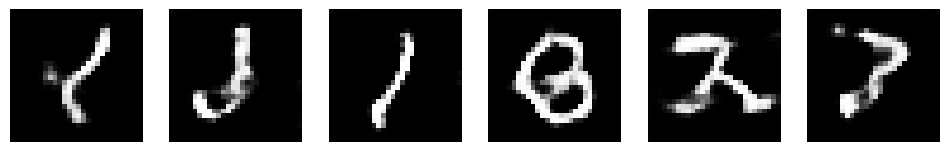

*** time now:  2023-06-01 17:16:28.472770
2/2 [==============================] - 0s 21ms/step
=== Iter: 9305 : d_loss_real: 0.621894002, d_loss_fake: 0.556768656, dcg_loss: 0.907438397 - in Epoch 10/20 - Batch 872/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9310 : d_loss_real: 0.633153975, d_loss_fake: 0.606897116, dcg_loss: 0.844605327 - in Epoch 10/20 - Batch 877/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9315 : d_loss_real: 0.603520989, d_loss_fake: 0.598529100, dcg_loss: 0.942163765 - in Epoch 10/20 - Batch 882/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9320 : d_loss_real: 0.694844365, d_loss_fake: 0.690677643, dcg_loss: 0.825107515 - in Epoch 10/20 - Batch 887/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9325 : d_loss_real: 0.694717348, d_loss_fake: 0.708338141, dcg_loss: 0.783100665 - in Epoch 10/20 - Batch 892/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9330 : d_loss_re

2/2 [==============================] - 0s 21ms/step
=== Iter: 9515 : d_loss_real: 0.785598636, d_loss_fake: 0.722682834, dcg_loss: 0.733621597 - in Epoch 11/20 - Batch 145/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9520 : d_loss_real: 0.785243750, d_loss_fake: 0.657778502, dcg_loss: 0.815494537 - in Epoch 11/20 - Batch 150/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9525 : d_loss_real: 0.853571713, d_loss_fake: 0.606821299, dcg_loss: 0.783326089 - in Epoch 11/20 - Batch 155/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9530 : d_loss_real: 0.750581861, d_loss_fake: 0.620019436, dcg_loss: 0.877662122 - in Epoch 11/20 - Batch 160/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9535 : d_loss_real: 0.720867872, d_loss_fake: 0.555429578, dcg_loss: 0.956410170 - in Epoch 11/20 - Batch 165/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9540 : d_loss_real: 0.669074297, d_loss_fake: 0.527823448,

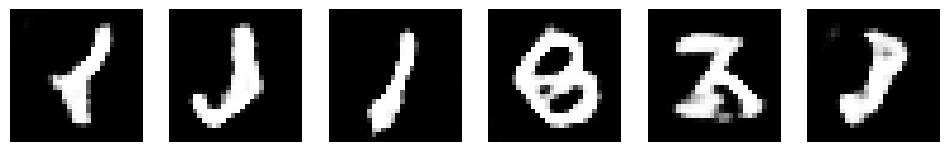

*** time now:  2023-06-01 17:17:53.050439
2/2 [==============================] - 0s 22ms/step
=== Iter: 9605 : d_loss_real: 0.612782836, d_loss_fake: 0.580197811, dcg_loss: 0.936317623 - in Epoch 11/20 - Batch 235/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 9610 : d_loss_real: 0.571085691, d_loss_fake: 0.550915003, dcg_loss: 0.955646753 - in Epoch 11/20 - Batch 240/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 9615 : d_loss_real: 0.515713215, d_loss_fake: 0.597619832, dcg_loss: 1.024082422 - in Epoch 11/20 - Batch 245/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9620 : d_loss_real: 0.627820075, d_loss_fake: 0.555183411, dcg_loss: 0.885552108 - in Epoch 11/20 - Batch 250/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9625 : d_loss_real: 0.565745413, d_loss_fake: 0.594399691, dcg_loss: 0.922299683 - in Epoch 11/20 - Batch 255/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9630 : d_loss_re

2/2 [==============================] - 0s 21ms/step
=== Iter: 9815 : d_loss_real: 0.657974720, d_loss_fake: 0.693866014, dcg_loss: 0.817341089 - in Epoch 11/20 - Batch 445/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9820 : d_loss_real: 0.682368755, d_loss_fake: 0.643000662, dcg_loss: 0.815746546 - in Epoch 11/20 - Batch 450/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9825 : d_loss_real: 0.633038640, d_loss_fake: 0.658052683, dcg_loss: 0.739028931 - in Epoch 11/20 - Batch 455/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9830 : d_loss_real: 0.757245123, d_loss_fake: 0.677146256, dcg_loss: 0.808488131 - in Epoch 11/20 - Batch 460/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9835 : d_loss_real: 0.701144993, d_loss_fake: 0.718490601, dcg_loss: 0.709459901 - in Epoch 11/20 - Batch 465/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 9840 : d_loss_real: 0.602206945, d_loss_fake: 0.787021577,

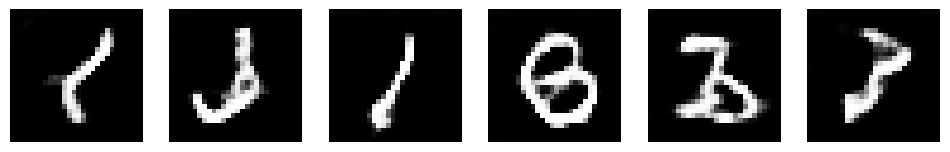

*** time now:  2023-06-01 17:19:18.978984
2/2 [==============================] - 0s 22ms/step
=== Iter: 9905 : d_loss_real: 0.802653670, d_loss_fake: 0.677079916, dcg_loss: 0.740157485 - in Epoch 11/20 - Batch 535/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 9910 : d_loss_real: 0.792410493, d_loss_fake: 0.645081222, dcg_loss: 0.856135666 - in Epoch 11/20 - Batch 540/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 9915 : d_loss_real: 0.697770059, d_loss_fake: 0.604496300, dcg_loss: 0.865267694 - in Epoch 11/20 - Batch 545/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 9920 : d_loss_real: 0.617331624, d_loss_fake: 0.573243082, dcg_loss: 0.981910169 - in Epoch 11/20 - Batch 550/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 9925 : d_loss_real: 0.641409636, d_loss_fake: 0.565491378, dcg_loss: 0.976566732 - in Epoch 11/20 - Batch 555/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 9930 : d_loss_re

2/2 [==============================] - 0s 24ms/step
=== Iter: 10115 : d_loss_real: 0.643920898, d_loss_fake: 0.627763271, dcg_loss: 0.823349118 - in Epoch 11/20 - Batch 745/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 10120 : d_loss_real: 0.560410678, d_loss_fake: 0.654205561, dcg_loss: 0.855347216 - in Epoch 11/20 - Batch 750/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 10125 : d_loss_real: 0.616290331, d_loss_fake: 0.664190233, dcg_loss: 0.862506330 - in Epoch 11/20 - Batch 755/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10130 : d_loss_real: 0.639613211, d_loss_fake: 0.581743658, dcg_loss: 0.953846693 - in Epoch 11/20 - Batch 760/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 10135 : d_loss_real: 0.626136243, d_loss_fake: 0.648754001, dcg_loss: 0.860594511 - in Epoch 11/20 - Batch 765/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 10140 : d_loss_real: 0.628125191, d_loss_fake: 0.6298

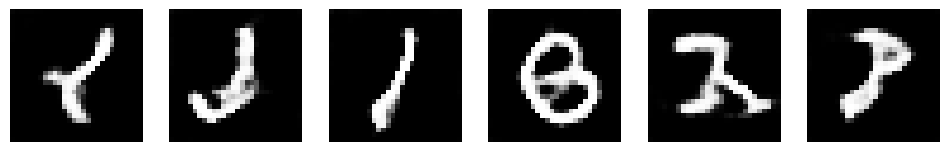

*** time now:  2023-06-01 17:20:50.332860
2/2 [==============================] - 0s 22ms/step
=== Iter: 10205 : d_loss_real: 0.753600359, d_loss_fake: 0.601881325, dcg_loss: 0.741099000 - in Epoch 11/20 - Batch 835/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10210 : d_loss_real: 0.638980567, d_loss_fake: 0.750292301, dcg_loss: 0.779854476 - in Epoch 11/20 - Batch 840/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 10215 : d_loss_real: 0.643123984, d_loss_fake: 0.719156027, dcg_loss: 0.706835210 - in Epoch 11/20 - Batch 845/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10220 : d_loss_real: 0.666359663, d_loss_fake: 0.739715278, dcg_loss: 0.809659362 - in Epoch 11/20 - Batch 850/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10225 : d_loss_real: 0.645726919, d_loss_fake: 0.736699104, dcg_loss: 0.722399712 - in Epoch 11/20 - Batch 855/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10230 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 10415 : d_loss_real: 0.700572371, d_loss_fake: 0.640898108, dcg_loss: 0.850314975 - in Epoch 12/20 - Batch 108/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10420 : d_loss_real: 0.685435891, d_loss_fake: 0.578011870, dcg_loss: 0.939487100 - in Epoch 12/20 - Batch 113/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10425 : d_loss_real: 0.667647123, d_loss_fake: 0.565657973, dcg_loss: 0.835271955 - in Epoch 12/20 - Batch 118/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10430 : d_loss_real: 0.580208302, d_loss_fake: 0.525278270, dcg_loss: 1.023146272 - in Epoch 12/20 - Batch 123/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10435 : d_loss_real: 0.639304161, d_loss_fake: 0.542502701, dcg_loss: 0.949768305 - in Epoch 12/20 - Batch 128/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 10440 : d_loss_real: 0.636552691, d_loss_fake: 0.6015

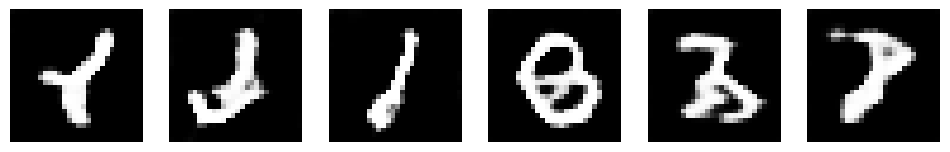

*** time now:  2023-06-01 17:22:15.564949
2/2 [==============================] - 0s 22ms/step
=== Iter: 10505 : d_loss_real: 0.632502496, d_loss_fake: 0.565148473, dcg_loss: 0.964944363 - in Epoch 12/20 - Batch 198/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 10510 : d_loss_real: 0.601472557, d_loss_fake: 0.642866015, dcg_loss: 0.838764429 - in Epoch 12/20 - Batch 203/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10515 : d_loss_real: 0.558570147, d_loss_fake: 0.639237404, dcg_loss: 0.903481603 - in Epoch 12/20 - Batch 208/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 10520 : d_loss_real: 0.734735131, d_loss_fake: 0.674192071, dcg_loss: 0.772690177 - in Epoch 12/20 - Batch 213/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10525 : d_loss_real: 0.651851773, d_loss_fake: 0.601094007, dcg_loss: 0.793115258 - in Epoch 12/20 - Batch 218/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10530 : d_l

2/2 [==============================] - 0s 21ms/step
=== Iter: 10715 : d_loss_real: 0.592402279, d_loss_fake: 0.701222181, dcg_loss: 0.829631329 - in Epoch 12/20 - Batch 408/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10720 : d_loss_real: 0.625545621, d_loss_fake: 0.624409914, dcg_loss: 0.835467756 - in Epoch 12/20 - Batch 413/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10725 : d_loss_real: 0.551030815, d_loss_fake: 0.632885993, dcg_loss: 0.819153368 - in Epoch 12/20 - Batch 418/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 10730 : d_loss_real: 0.607263386, d_loss_fake: 0.615010858, dcg_loss: 0.829887152 - in Epoch 12/20 - Batch 423/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 10735 : d_loss_real: 0.592174292, d_loss_fake: 0.591579199, dcg_loss: 0.831762493 - in Epoch 12/20 - Batch 428/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10740 : d_loss_real: 0.587465405, d_loss_fake: 0.5749

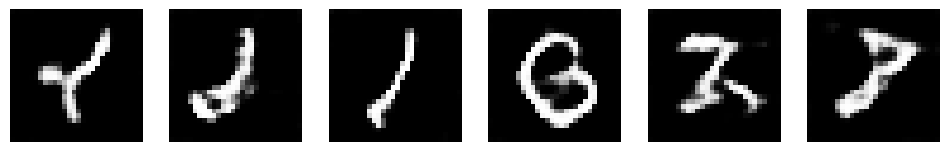

*** time now:  2023-06-01 17:23:42.881908
2/2 [==============================] - 0s 28ms/step
=== Iter: 10805 : d_loss_real: 0.638883948, d_loss_fake: 0.590801001, dcg_loss: 0.941995740 - in Epoch 12/20 - Batch 498/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 10810 : d_loss_real: 0.555679381, d_loss_fake: 0.638251245, dcg_loss: 0.832140863 - in Epoch 12/20 - Batch 503/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 10815 : d_loss_real: 0.654472828, d_loss_fake: 0.614997387, dcg_loss: 0.906784594 - in Epoch 12/20 - Batch 508/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10820 : d_loss_real: 0.569761038, d_loss_fake: 0.664329767, dcg_loss: 0.880015671 - in Epoch 12/20 - Batch 513/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10825 : d_loss_real: 0.588507950, d_loss_fake: 0.637458324, dcg_loss: 0.827588141 - in Epoch 12/20 - Batch 518/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 10830 : d_l

2/2 [==============================] - 0s 29ms/step
=== Iter: 11015 : d_loss_real: 0.600904703, d_loss_fake: 0.646187305, dcg_loss: 0.836170614 - in Epoch 12/20 - Batch 708/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 11020 : d_loss_real: 0.712902963, d_loss_fake: 0.649795413, dcg_loss: 0.720526338 - in Epoch 12/20 - Batch 713/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11025 : d_loss_real: 0.665261984, d_loss_fake: 0.706479788, dcg_loss: 0.713827133 - in Epoch 12/20 - Batch 718/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 11030 : d_loss_real: 0.759721756, d_loss_fake: 0.699568152, dcg_loss: 0.757851660 - in Epoch 12/20 - Batch 723/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11035 : d_loss_real: 0.765588284, d_loss_fake: 0.641793251, dcg_loss: 0.933054864 - in Epoch 12/20 - Batch 728/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11040 : d_loss_real: 0.759666562, d_loss_fake: 0.5414

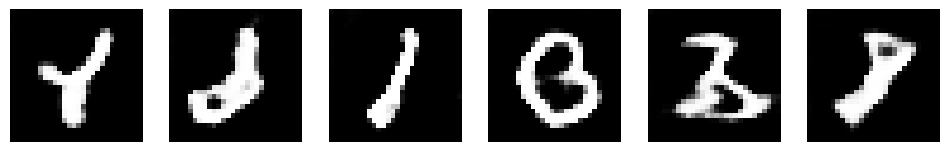

*** time now:  2023-06-01 17:25:10.820473
2/2 [==============================] - 0s 23ms/step
=== Iter: 11105 : d_loss_real: 0.645000577, d_loss_fake: 0.658342838, dcg_loss: 0.841137230 - in Epoch 12/20 - Batch 798/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 11110 : d_loss_real: 0.593939781, d_loss_fake: 0.614116192, dcg_loss: 0.882362127 - in Epoch 12/20 - Batch 803/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 11115 : d_loss_real: 0.547833800, d_loss_fake: 0.641624928, dcg_loss: 0.955874026 - in Epoch 12/20 - Batch 808/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11120 : d_loss_real: 0.520602822, d_loss_fake: 0.599302769, dcg_loss: 0.878031254 - in Epoch 12/20 - Batch 813/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11125 : d_loss_real: 0.595992327, d_loss_fake: 0.612243533, dcg_loss: 0.982554674 - in Epoch 12/20 - Batch 818/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11130 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 11315 : d_loss_real: 0.682812691, d_loss_fake: 0.585655630, dcg_loss: 1.044780731 - in Epoch 13/20 - Batch 71/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11320 : d_loss_real: 0.602033138, d_loss_fake: 0.586162329, dcg_loss: 0.860083878 - in Epoch 13/20 - Batch 76/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11325 : d_loss_real: 0.570804358, d_loss_fake: 0.601563394, dcg_loss: 0.943826795 - in Epoch 13/20 - Batch 81/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11330 : d_loss_real: 0.613651872, d_loss_fake: 0.601381242, dcg_loss: 0.982502580 - in Epoch 13/20 - Batch 86/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11335 : d_loss_real: 0.633366585, d_loss_fake: 0.624452770, dcg_loss: 0.866156340 - in Epoch 13/20 - Batch 91/937
2/2 [==============================] - 0s 30ms/step
=== Iter: 11340 : d_loss_real: 0.485534370, d_loss_fake: 0.653464079

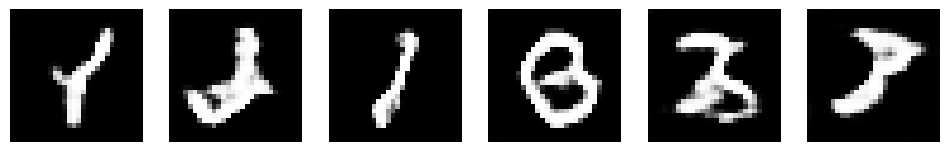

*** time now:  2023-06-01 17:26:42.021135
2/2 [==============================] - 0s 22ms/step
=== Iter: 11405 : d_loss_real: 0.640582442, d_loss_fake: 0.645334899, dcg_loss: 0.796551347 - in Epoch 13/20 - Batch 161/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11410 : d_loss_real: 0.590316057, d_loss_fake: 0.670667052, dcg_loss: 0.812901735 - in Epoch 13/20 - Batch 166/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 11415 : d_loss_real: 0.654778600, d_loss_fake: 0.662360668, dcg_loss: 0.823932886 - in Epoch 13/20 - Batch 171/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11420 : d_loss_real: 0.633648515, d_loss_fake: 0.627644718, dcg_loss: 0.772125959 - in Epoch 13/20 - Batch 176/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11425 : d_loss_real: 0.733345926, d_loss_fake: 0.543449104, dcg_loss: 0.937093735 - in Epoch 13/20 - Batch 181/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11430 : d_l

2/2 [==============================] - 0s 24ms/step
=== Iter: 11615 : d_loss_real: 0.610048771, d_loss_fake: 0.684171915, dcg_loss: 0.794011235 - in Epoch 13/20 - Batch 371/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11620 : d_loss_real: 0.671530664, d_loss_fake: 0.657419503, dcg_loss: 0.826136112 - in Epoch 13/20 - Batch 376/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11625 : d_loss_real: 0.610543251, d_loss_fake: 0.613298833, dcg_loss: 0.855206788 - in Epoch 13/20 - Batch 381/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11630 : d_loss_real: 0.552585363, d_loss_fake: 0.585792422, dcg_loss: 0.854623497 - in Epoch 13/20 - Batch 386/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11635 : d_loss_real: 0.559226274, d_loss_fake: 0.576654792, dcg_loss: 0.950894117 - in Epoch 13/20 - Batch 391/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11640 : d_loss_real: 0.591209531, d_loss_fake: 0.5636

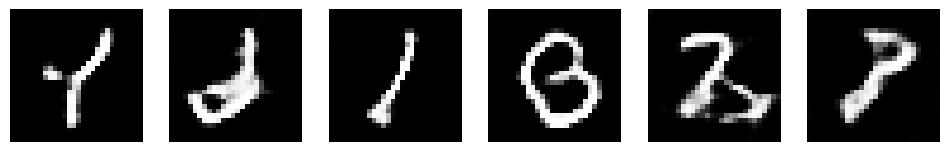

*** time now:  2023-06-01 17:28:05.930174
2/2 [==============================] - 0s 19ms/step
=== Iter: 11705 : d_loss_real: 0.665131211, d_loss_fake: 0.587215245, dcg_loss: 0.931349933 - in Epoch 13/20 - Batch 461/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 11710 : d_loss_real: 0.640521407, d_loss_fake: 0.563148737, dcg_loss: 0.925036013 - in Epoch 13/20 - Batch 466/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 11715 : d_loss_real: 0.622657895, d_loss_fake: 0.641727865, dcg_loss: 0.885385633 - in Epoch 13/20 - Batch 471/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 11720 : d_loss_real: 0.600369930, d_loss_fake: 0.603870630, dcg_loss: 0.913142562 - in Epoch 13/20 - Batch 476/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 11725 : d_loss_real: 0.647996187, d_loss_fake: 0.705212831, dcg_loss: 0.794986367 - in Epoch 13/20 - Batch 481/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 11730 : d_l

2/2 [==============================] - 0s 21ms/step
=== Iter: 11915 : d_loss_real: 0.545394778, d_loss_fake: 0.536098301, dcg_loss: 0.957480192 - in Epoch 13/20 - Batch 671/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 11920 : d_loss_real: 0.654319465, d_loss_fake: 0.572457552, dcg_loss: 0.928315163 - in Epoch 13/20 - Batch 676/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 11925 : d_loss_real: 0.616333365, d_loss_fake: 0.615218043, dcg_loss: 0.912543893 - in Epoch 13/20 - Batch 681/937
2/2 [==============================] - 0s 37ms/step
=== Iter: 11930 : d_loss_real: 0.520728409, d_loss_fake: 0.604860783, dcg_loss: 0.916079104 - in Epoch 13/20 - Batch 686/937
2/2 [==============================] - 0s 29ms/step
=== Iter: 11935 : d_loss_real: 0.607753277, d_loss_fake: 0.612033427, dcg_loss: 0.878663003 - in Epoch 13/20 - Batch 691/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 11940 : d_loss_real: 0.635958195, d_loss_fake: 0.6256

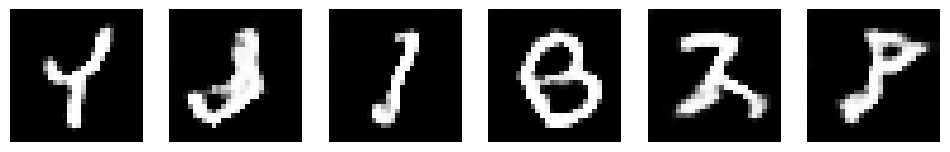

*** time now:  2023-06-01 17:29:35.631248
2/2 [==============================] - 0s 35ms/step
=== Iter: 12005 : d_loss_real: 0.632363558, d_loss_fake: 0.802124202, dcg_loss: 0.753936052 - in Epoch 13/20 - Batch 761/937
2/2 [==============================] - 1s 61ms/step
=== Iter: 12010 : d_loss_real: 0.643766820, d_loss_fake: 0.657365143, dcg_loss: 0.849569023 - in Epoch 13/20 - Batch 766/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 12015 : d_loss_real: 0.667153895, d_loss_fake: 0.578399479, dcg_loss: 0.836322308 - in Epoch 13/20 - Batch 771/937
2/2 [==============================] - 0s 37ms/step
=== Iter: 12020 : d_loss_real: 0.606838226, d_loss_fake: 0.612425148, dcg_loss: 0.766614974 - in Epoch 13/20 - Batch 776/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 12025 : d_loss_real: 0.595976412, d_loss_fake: 0.621168256, dcg_loss: 0.836050034 - in Epoch 13/20 - Batch 781/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12030 : d_l

2/2 [==============================] - 0s 20ms/step
=== Iter: 12215 : d_loss_real: 0.700888991, d_loss_fake: 0.521822810, dcg_loss: 0.962919474 - in Epoch 14/20 - Batch 34/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12220 : d_loss_real: 0.646355450, d_loss_fake: 0.600027800, dcg_loss: 0.899134338 - in Epoch 14/20 - Batch 39/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12225 : d_loss_real: 0.650015712, d_loss_fake: 0.619364858, dcg_loss: 0.903603017 - in Epoch 14/20 - Batch 44/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12230 : d_loss_real: 0.623139322, d_loss_fake: 0.605259061, dcg_loss: 1.023728609 - in Epoch 14/20 - Batch 49/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12235 : d_loss_real: 0.624523342, d_loss_fake: 0.622189164, dcg_loss: 0.968404531 - in Epoch 14/20 - Batch 54/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12240 : d_loss_real: 0.676865578, d_loss_fake: 0.581122875

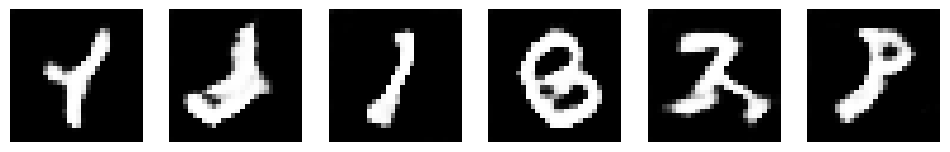

*** time now:  2023-06-01 17:31:16.008819
2/2 [==============================] - 0s 22ms/step
=== Iter: 12305 : d_loss_real: 0.549183607, d_loss_fake: 0.652386069, dcg_loss: 1.015017986 - in Epoch 14/20 - Batch 124/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12310 : d_loss_real: 0.559192896, d_loss_fake: 0.570426643, dcg_loss: 1.029909372 - in Epoch 14/20 - Batch 129/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12315 : d_loss_real: 0.646178246, d_loss_fake: 0.567334414, dcg_loss: 1.043796897 - in Epoch 14/20 - Batch 134/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12320 : d_loss_real: 0.535494626, d_loss_fake: 0.598764300, dcg_loss: 0.934782624 - in Epoch 14/20 - Batch 139/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12325 : d_loss_real: 0.602741957, d_loss_fake: 0.590142488, dcg_loss: 0.776253343 - in Epoch 14/20 - Batch 144/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 12330 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 12515 : d_loss_real: 0.585900724, d_loss_fake: 0.614957213, dcg_loss: 0.884436727 - in Epoch 14/20 - Batch 334/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12520 : d_loss_real: 0.655565381, d_loss_fake: 0.634927511, dcg_loss: 0.872908890 - in Epoch 14/20 - Batch 339/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12525 : d_loss_real: 0.670287609, d_loss_fake: 0.694410443, dcg_loss: 0.878070474 - in Epoch 14/20 - Batch 344/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12530 : d_loss_real: 0.605038881, d_loss_fake: 0.694208801, dcg_loss: 0.810000241 - in Epoch 14/20 - Batch 349/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 12535 : d_loss_real: 0.599022865, d_loss_fake: 0.671028078, dcg_loss: 0.885736585 - in Epoch 14/20 - Batch 354/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 12540 : d_loss_real: 0.685551047, d_loss_fake: 0.6397

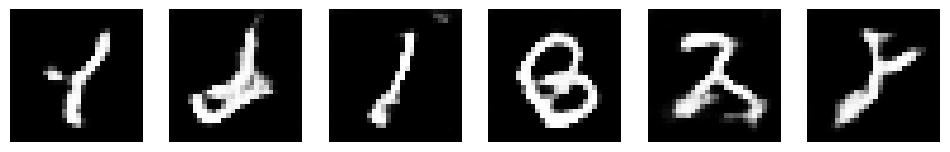

*** time now:  2023-06-01 17:32:40.678278
2/2 [==============================] - 0s 22ms/step
=== Iter: 12605 : d_loss_real: 0.667951763, d_loss_fake: 0.678176761, dcg_loss: 0.882257223 - in Epoch 14/20 - Batch 424/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12610 : d_loss_real: 0.654488206, d_loss_fake: 0.625052869, dcg_loss: 0.855673432 - in Epoch 14/20 - Batch 429/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12615 : d_loss_real: 0.663666904, d_loss_fake: 0.604966938, dcg_loss: 0.916225493 - in Epoch 14/20 - Batch 434/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12620 : d_loss_real: 0.651219845, d_loss_fake: 0.611515701, dcg_loss: 0.876987398 - in Epoch 14/20 - Batch 439/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12625 : d_loss_real: 0.652890503, d_loss_fake: 0.674283624, dcg_loss: 0.875579059 - in Epoch 14/20 - Batch 444/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12630 : d_l

2/2 [==============================] - 0s 32ms/step
=== Iter: 12815 : d_loss_real: 0.680350959, d_loss_fake: 0.659619510, dcg_loss: 0.831269026 - in Epoch 14/20 - Batch 634/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12820 : d_loss_real: 0.612019539, d_loss_fake: 0.627397716, dcg_loss: 0.889042318 - in Epoch 14/20 - Batch 639/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 12825 : d_loss_real: 0.576667905, d_loss_fake: 0.623285651, dcg_loss: 0.944032550 - in Epoch 14/20 - Batch 644/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12830 : d_loss_real: 0.603734255, d_loss_fake: 0.571841359, dcg_loss: 0.961166620 - in Epoch 14/20 - Batch 649/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12835 : d_loss_real: 0.587797165, d_loss_fake: 0.620324135, dcg_loss: 0.979496241 - in Epoch 14/20 - Batch 654/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 12840 : d_loss_real: 0.673811793, d_loss_fake: 0.5539

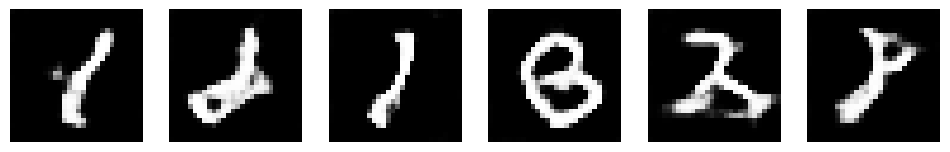

*** time now:  2023-06-01 17:34:17.122584
2/2 [==============================] - 0s 21ms/step
=== Iter: 12905 : d_loss_real: 0.664802015, d_loss_fake: 0.589897573, dcg_loss: 0.837124944 - in Epoch 14/20 - Batch 724/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12910 : d_loss_real: 0.612762570, d_loss_fake: 0.629601598, dcg_loss: 0.805234671 - in Epoch 14/20 - Batch 729/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 12915 : d_loss_real: 0.640309334, d_loss_fake: 0.685477316, dcg_loss: 0.809635162 - in Epoch 14/20 - Batch 734/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 12920 : d_loss_real: 0.680042803, d_loss_fake: 0.627743840, dcg_loss: 0.844130278 - in Epoch 14/20 - Batch 739/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 12925 : d_loss_real: 0.671962380, d_loss_fake: 0.630100250, dcg_loss: 0.816133499 - in Epoch 14/20 - Batch 744/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 12930 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 13115 : d_loss_real: 0.720795989, d_loss_fake: 0.662279606, dcg_loss: 0.868863583 - in Epoch 14/20 - Batch 934/937
2/2 [==============================] - 0s 136ms/step
=== Iter: 13120 : d_loss_real: 0.675310373, d_loss_fake: 0.558114290, dcg_loss: 0.912718356 - in Epoch 15/20 - Batch 2/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 13125 : d_loss_real: 0.701731086, d_loss_fake: 0.515399575, dcg_loss: 1.003365397 - in Epoch 15/20 - Batch 7/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13130 : d_loss_real: 0.614578009, d_loss_fake: 0.636345804, dcg_loss: 0.954081416 - in Epoch 15/20 - Batch 12/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13135 : d_loss_real: 0.658561766, d_loss_fake: 0.597775459, dcg_loss: 0.962135017 - in Epoch 15/20 - Batch 17/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13140 : d_loss_real: 0.653931379, d_loss_fake: 0.572277069

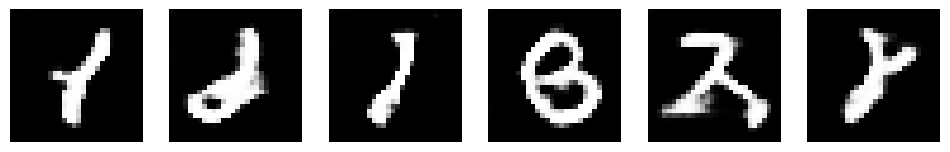

*** time now:  2023-06-01 17:35:43.016035
2/2 [==============================] - 0s 35ms/step
=== Iter: 13205 : d_loss_real: 0.585132837, d_loss_fake: 0.558246374, dcg_loss: 0.950214803 - in Epoch 15/20 - Batch 87/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13210 : d_loss_real: 0.567664027, d_loss_fake: 0.630191505, dcg_loss: 0.913468242 - in Epoch 15/20 - Batch 92/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13215 : d_loss_real: 0.548191369, d_loss_fake: 0.631855845, dcg_loss: 0.984329343 - in Epoch 15/20 - Batch 97/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13220 : d_loss_real: 0.561626434, d_loss_fake: 0.605441093, dcg_loss: 0.910500348 - in Epoch 15/20 - Batch 102/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13225 : d_loss_real: 0.648573875, d_loss_fake: 0.655204535, dcg_loss: 0.920498013 - in Epoch 15/20 - Batch 107/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 13230 : d_loss

2/2 [==============================] - 0s 21ms/step
=== Iter: 13415 : d_loss_real: 0.704396605, d_loss_fake: 0.631191134, dcg_loss: 0.765529871 - in Epoch 15/20 - Batch 297/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13420 : d_loss_real: 0.557849646, d_loss_fake: 0.655035019, dcg_loss: 0.786308229 - in Epoch 15/20 - Batch 302/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13425 : d_loss_real: 0.618340492, d_loss_fake: 0.630919456, dcg_loss: 0.838077426 - in Epoch 15/20 - Batch 307/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13430 : d_loss_real: 0.661715031, d_loss_fake: 0.623018086, dcg_loss: 0.820080876 - in Epoch 15/20 - Batch 312/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13435 : d_loss_real: 0.661860049, d_loss_fake: 0.640404344, dcg_loss: 0.895585001 - in Epoch 15/20 - Batch 317/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13440 : d_loss_real: 0.566031992, d_loss_fake: 0.6386

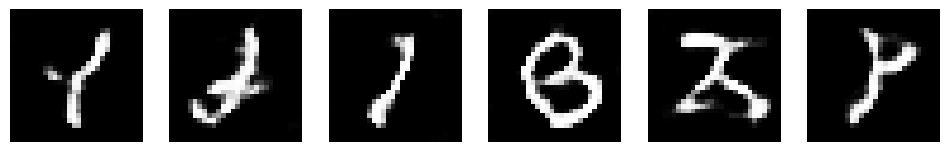

*** time now:  2023-06-01 17:37:12.607117
2/2 [==============================] - 0s 22ms/step
=== Iter: 13505 : d_loss_real: 0.574029565, d_loss_fake: 0.525098979, dcg_loss: 0.884906292 - in Epoch 15/20 - Batch 387/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13510 : d_loss_real: 0.596912086, d_loss_fake: 0.636342049, dcg_loss: 0.879952312 - in Epoch 15/20 - Batch 392/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13515 : d_loss_real: 0.681843102, d_loss_fake: 0.631620586, dcg_loss: 0.958166838 - in Epoch 15/20 - Batch 397/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13520 : d_loss_real: 0.660330772, d_loss_fake: 0.574195385, dcg_loss: 0.923873127 - in Epoch 15/20 - Batch 402/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 13525 : d_loss_real: 0.607183695, d_loss_fake: 0.690623224, dcg_loss: 0.818299949 - in Epoch 15/20 - Batch 407/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13530 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 13715 : d_loss_real: 0.740504384, d_loss_fake: 0.748287916, dcg_loss: 0.806063652 - in Epoch 15/20 - Batch 597/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13720 : d_loss_real: 0.677239597, d_loss_fake: 0.610144019, dcg_loss: 0.799232244 - in Epoch 15/20 - Batch 602/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13725 : d_loss_real: 0.746352613, d_loss_fake: 0.535742462, dcg_loss: 1.011164665 - in Epoch 15/20 - Batch 607/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13730 : d_loss_real: 0.605907202, d_loss_fake: 0.512676775, dcg_loss: 0.979865789 - in Epoch 15/20 - Batch 612/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13735 : d_loss_real: 0.583866894, d_loss_fake: 0.532693863, dcg_loss: 1.028690457 - in Epoch 15/20 - Batch 617/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13740 : d_loss_real: 0.554230690, d_loss_fake: 0.4731

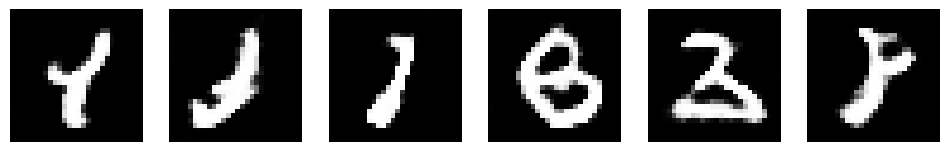

*** time now:  2023-06-01 17:38:36.068400
2/2 [==============================] - 0s 21ms/step
=== Iter: 13805 : d_loss_real: 0.567962646, d_loss_fake: 0.549792767, dcg_loss: 0.917790890 - in Epoch 15/20 - Batch 687/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 13810 : d_loss_real: 0.565648258, d_loss_fake: 0.620319068, dcg_loss: 1.062797546 - in Epoch 15/20 - Batch 692/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13815 : d_loss_real: 0.561455488, d_loss_fake: 0.608539820, dcg_loss: 1.044218302 - in Epoch 15/20 - Batch 697/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13820 : d_loss_real: 0.643349767, d_loss_fake: 0.632106185, dcg_loss: 0.924252272 - in Epoch 15/20 - Batch 702/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 13825 : d_loss_real: 0.608134866, d_loss_fake: 0.632149398, dcg_loss: 0.896449089 - in Epoch 15/20 - Batch 707/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 13830 : d_l

2/2 [==============================] - 0s 21ms/step
=== Iter: 14015 : d_loss_real: 0.620522141, d_loss_fake: 0.754201770, dcg_loss: 0.781520486 - in Epoch 15/20 - Batch 897/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14020 : d_loss_real: 0.635831475, d_loss_fake: 0.727061927, dcg_loss: 0.754560530 - in Epoch 15/20 - Batch 902/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 14025 : d_loss_real: 0.600327730, d_loss_fake: 0.664470792, dcg_loss: 0.779189765 - in Epoch 15/20 - Batch 907/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14030 : d_loss_real: 0.700773716, d_loss_fake: 0.637336612, dcg_loss: 0.824264944 - in Epoch 15/20 - Batch 912/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14035 : d_loss_real: 0.581074715, d_loss_fake: 0.741546035, dcg_loss: 0.824767888 - in Epoch 15/20 - Batch 917/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14040 : d_loss_real: 0.563244998, d_loss_fake: 0.6006

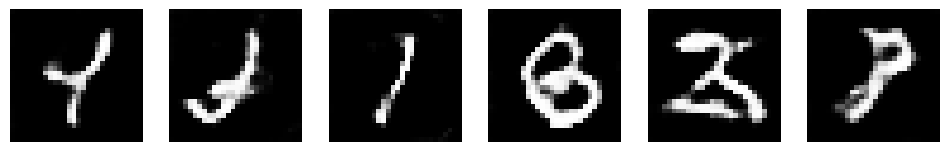

*** time now:  2023-06-01 17:40:00.462980
2/2 [==============================] - 0s 22ms/step
=== Iter: 14105 : d_loss_real: 0.712575614, d_loss_fake: 0.584866524, dcg_loss: 0.961381674 - in Epoch 16/20 - Batch 50/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 14110 : d_loss_real: 0.629086852, d_loss_fake: 0.554582238, dcg_loss: 1.152084351 - in Epoch 16/20 - Batch 55/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14115 : d_loss_real: 0.587568998, d_loss_fake: 0.500504375, dcg_loss: 1.001555204 - in Epoch 16/20 - Batch 60/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14120 : d_loss_real: 0.620493054, d_loss_fake: 0.490887880, dcg_loss: 1.062102795 - in Epoch 16/20 - Batch 65/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 14125 : d_loss_real: 0.655040085, d_loss_fake: 0.587444425, dcg_loss: 0.967004657 - in Epoch 16/20 - Batch 70/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14130 : d_loss_r

2/2 [==============================] - 0s 20ms/step
=== Iter: 14315 : d_loss_real: 0.567923784, d_loss_fake: 0.660804868, dcg_loss: 0.863064587 - in Epoch 16/20 - Batch 260/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 14320 : d_loss_real: 0.555700123, d_loss_fake: 0.604531944, dcg_loss: 0.962810695 - in Epoch 16/20 - Batch 265/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14325 : d_loss_real: 0.541346788, d_loss_fake: 0.598133564, dcg_loss: 0.883877099 - in Epoch 16/20 - Batch 270/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14330 : d_loss_real: 0.521034837, d_loss_fake: 0.530817866, dcg_loss: 1.020006180 - in Epoch 16/20 - Batch 275/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14335 : d_loss_real: 0.624853671, d_loss_fake: 0.540655255, dcg_loss: 1.064557076 - in Epoch 16/20 - Batch 280/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14340 : d_loss_real: 0.576452732, d_loss_fake: 0.5895

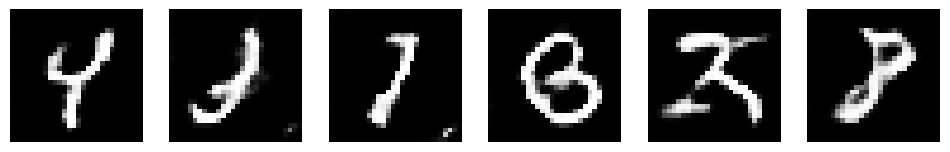

*** time now:  2023-06-01 17:41:24.724586
2/2 [==============================] - 0s 21ms/step
=== Iter: 14405 : d_loss_real: 0.586347103, d_loss_fake: 0.588909984, dcg_loss: 0.892959595 - in Epoch 16/20 - Batch 350/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14410 : d_loss_real: 0.669123054, d_loss_fake: 0.570380867, dcg_loss: 0.881396174 - in Epoch 16/20 - Batch 355/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14415 : d_loss_real: 0.613190651, d_loss_fake: 0.613399625, dcg_loss: 0.840524077 - in Epoch 16/20 - Batch 360/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14420 : d_loss_real: 0.690266550, d_loss_fake: 0.675385475, dcg_loss: 0.837066293 - in Epoch 16/20 - Batch 365/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14425 : d_loss_real: 0.582544923, d_loss_fake: 0.682073951, dcg_loss: 0.855285048 - in Epoch 16/20 - Batch 370/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14430 : d_l

2/2 [==============================] - 0s 21ms/step
=== Iter: 14615 : d_loss_real: 0.608934820, d_loss_fake: 0.576664507, dcg_loss: 1.072678924 - in Epoch 16/20 - Batch 560/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14620 : d_loss_real: 0.532948256, d_loss_fake: 0.586348772, dcg_loss: 0.865858853 - in Epoch 16/20 - Batch 565/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14625 : d_loss_real: 0.628632665, d_loss_fake: 0.626082778, dcg_loss: 0.930243075 - in Epoch 16/20 - Batch 570/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14630 : d_loss_real: 0.684533775, d_loss_fake: 0.601384282, dcg_loss: 0.884156227 - in Epoch 16/20 - Batch 575/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14635 : d_loss_real: 0.702277482, d_loss_fake: 0.609483242, dcg_loss: 0.837808788 - in Epoch 16/20 - Batch 580/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14640 : d_loss_real: 0.715470195, d_loss_fake: 0.5955

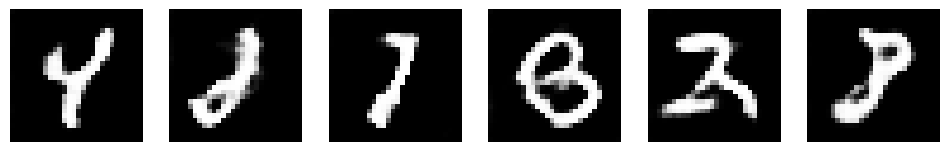

*** time now:  2023-06-01 17:42:46.515807
2/2 [==============================] - 0s 21ms/step
=== Iter: 14705 : d_loss_real: 0.683553934, d_loss_fake: 0.643827677, dcg_loss: 0.769592524 - in Epoch 16/20 - Batch 650/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14710 : d_loss_real: 0.614835024, d_loss_fake: 0.679683387, dcg_loss: 0.795692503 - in Epoch 16/20 - Batch 655/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14715 : d_loss_real: 0.580131292, d_loss_fake: 0.665586293, dcg_loss: 0.867569268 - in Epoch 16/20 - Batch 660/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14720 : d_loss_real: 0.604443073, d_loss_fake: 0.620979488, dcg_loss: 0.796076357 - in Epoch 16/20 - Batch 665/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14725 : d_loss_real: 0.628941417, d_loss_fake: 0.588330984, dcg_loss: 1.001440048 - in Epoch 16/20 - Batch 670/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 14730 : d_l

2/2 [==============================] - 0s 20ms/step
=== Iter: 14915 : d_loss_real: 0.745835185, d_loss_fake: 0.639700711, dcg_loss: 0.797632396 - in Epoch 16/20 - Batch 860/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14920 : d_loss_real: 0.638978660, d_loss_fake: 0.565158725, dcg_loss: 0.901055932 - in Epoch 16/20 - Batch 865/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14925 : d_loss_real: 0.720517576, d_loss_fake: 0.579639077, dcg_loss: 1.006273985 - in Epoch 16/20 - Batch 870/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 14930 : d_loss_real: 0.640450895, d_loss_fake: 0.516154230, dcg_loss: 0.991002679 - in Epoch 16/20 - Batch 875/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 14935 : d_loss_real: 0.659236789, d_loss_fake: 0.618688762, dcg_loss: 0.921417952 - in Epoch 16/20 - Batch 880/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 14940 : d_loss_real: 0.661228657, d_loss_fake: 0.5849

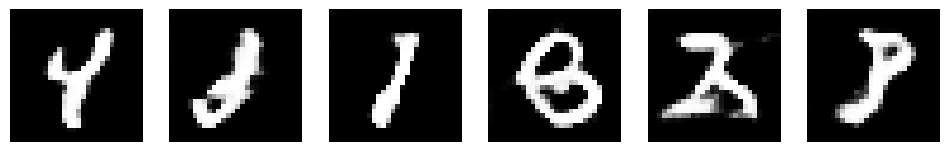

*** time now:  2023-06-01 17:44:12.026542
2/2 [==============================] - 0s 21ms/step
=== Iter: 15005 : d_loss_real: 0.548026860, d_loss_fake: 0.537940204, dcg_loss: 0.962851465 - in Epoch 17/20 - Batch 13/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15010 : d_loss_real: 0.557031870, d_loss_fake: 0.515740812, dcg_loss: 0.940740466 - in Epoch 17/20 - Batch 18/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15015 : d_loss_real: 0.504264832, d_loss_fake: 0.488376141, dcg_loss: 1.028548002 - in Epoch 17/20 - Batch 23/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15020 : d_loss_real: 0.608125687, d_loss_fake: 0.588822365, dcg_loss: 0.976000071 - in Epoch 17/20 - Batch 28/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15025 : d_loss_real: 0.608002007, d_loss_fake: 0.560095191, dcg_loss: 0.885455251 - in Epoch 17/20 - Batch 33/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15030 : d_loss_r

2/2 [==============================] - 0s 21ms/step
=== Iter: 15215 : d_loss_real: 0.656123221, d_loss_fake: 0.618960977, dcg_loss: 0.967224181 - in Epoch 17/20 - Batch 223/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 15220 : d_loss_real: 0.539460003, d_loss_fake: 0.537567437, dcg_loss: 0.894829392 - in Epoch 17/20 - Batch 228/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15225 : d_loss_real: 0.603840828, d_loss_fake: 0.605455041, dcg_loss: 0.886686563 - in Epoch 17/20 - Batch 233/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15230 : d_loss_real: 0.631506741, d_loss_fake: 0.636858284, dcg_loss: 0.889063776 - in Epoch 17/20 - Batch 238/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15235 : d_loss_real: 0.597566128, d_loss_fake: 0.721823275, dcg_loss: 0.873022377 - in Epoch 17/20 - Batch 243/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15240 : d_loss_real: 0.666132927, d_loss_fake: 0.5967

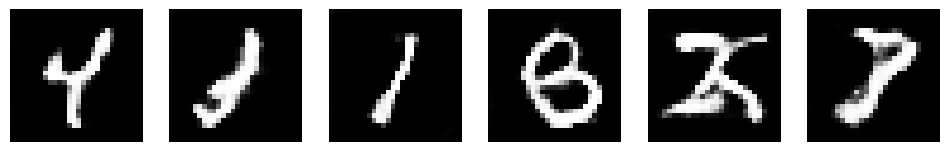

*** time now:  2023-06-01 17:45:36.653977
2/2 [==============================] - 0s 21ms/step
=== Iter: 15305 : d_loss_real: 0.623078823, d_loss_fake: 0.628767431, dcg_loss: 0.912564278 - in Epoch 17/20 - Batch 313/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15310 : d_loss_real: 0.655256152, d_loss_fake: 0.529926896, dcg_loss: 0.916812360 - in Epoch 17/20 - Batch 318/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15315 : d_loss_real: 0.650710106, d_loss_fake: 0.617710471, dcg_loss: 0.903230190 - in Epoch 17/20 - Batch 323/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15320 : d_loss_real: 0.579945326, d_loss_fake: 0.602067649, dcg_loss: 0.940405548 - in Epoch 17/20 - Batch 328/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 15325 : d_loss_real: 0.658000529, d_loss_fake: 0.556072414, dcg_loss: 0.987938523 - in Epoch 17/20 - Batch 333/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 15330 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 15515 : d_loss_real: 0.628413677, d_loss_fake: 0.610891223, dcg_loss: 0.912835240 - in Epoch 17/20 - Batch 523/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15520 : d_loss_real: 0.613583386, d_loss_fake: 0.616227150, dcg_loss: 0.835328341 - in Epoch 17/20 - Batch 528/937
2/2 [==============================] - 1s 173ms/step
=== Iter: 15525 : d_loss_real: 0.589094877, d_loss_fake: 0.601909995, dcg_loss: 0.895133615 - in Epoch 17/20 - Batch 533/937
2/2 [==============================] - 0s 55ms/step
=== Iter: 15530 : d_loss_real: 0.625981927, d_loss_fake: 0.596518159, dcg_loss: 0.860369563 - in Epoch 17/20 - Batch 538/937
2/2 [==============================] - 0s 58ms/step
=== Iter: 15535 : d_loss_real: 0.651487708, d_loss_fake: 0.603014588, dcg_loss: 0.918992758 - in Epoch 17/20 - Batch 543/937
2/2 [==============================] - 0s 67ms/step
=== Iter: 15540 : d_loss_real: 0.614658594, d_loss_fake: 0.554

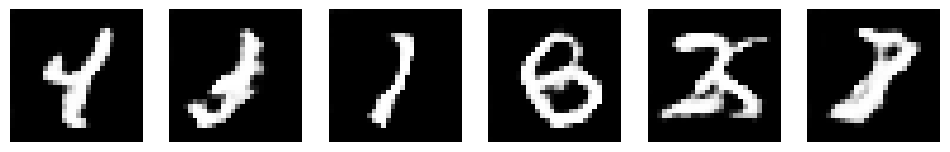

*** time now:  2023-06-01 17:47:38.832433
2/2 [==============================] - 0s 31ms/step
=== Iter: 15605 : d_loss_real: 0.628682256, d_loss_fake: 0.627196670, dcg_loss: 0.840463698 - in Epoch 17/20 - Batch 613/937
2/2 [==============================] - 0s 47ms/step
=== Iter: 15610 : d_loss_real: 0.596716464, d_loss_fake: 0.617792130, dcg_loss: 0.794732034 - in Epoch 17/20 - Batch 618/937
2/2 [==============================] - 0s 31ms/step
=== Iter: 15615 : d_loss_real: 0.591510475, d_loss_fake: 0.615991712, dcg_loss: 0.874794364 - in Epoch 17/20 - Batch 623/937
2/2 [==============================] - 0s 33ms/step
=== Iter: 15620 : d_loss_real: 0.629634321, d_loss_fake: 0.626885295, dcg_loss: 0.928970993 - in Epoch 17/20 - Batch 628/937
2/2 [==============================] - 0s 26ms/step
=== Iter: 15625 : d_loss_real: 0.679153323, d_loss_fake: 0.699460745, dcg_loss: 0.876074314 - in Epoch 17/20 - Batch 633/937
2/2 [==============================] - 0s 34ms/step
=== Iter: 15630 : d_l

2/2 [==============================] - 0s 18ms/step
=== Iter: 15815 : d_loss_real: 0.645502031, d_loss_fake: 0.664770484, dcg_loss: 0.789759040 - in Epoch 17/20 - Batch 823/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 15820 : d_loss_real: 0.525140643, d_loss_fake: 0.659113050, dcg_loss: 0.923755884 - in Epoch 17/20 - Batch 828/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 15825 : d_loss_real: 0.610392630, d_loss_fake: 0.575148463, dcg_loss: 0.903596640 - in Epoch 17/20 - Batch 833/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 15830 : d_loss_real: 0.556270838, d_loss_fake: 0.565500855, dcg_loss: 0.872551858 - in Epoch 17/20 - Batch 838/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 15835 : d_loss_real: 0.545502484, d_loss_fake: 0.614871562, dcg_loss: 0.966331482 - in Epoch 17/20 - Batch 843/937
2/2 [==============================] - 0s 37ms/step
=== Iter: 15840 : d_loss_real: 0.659682095, d_loss_fake: 0.5854

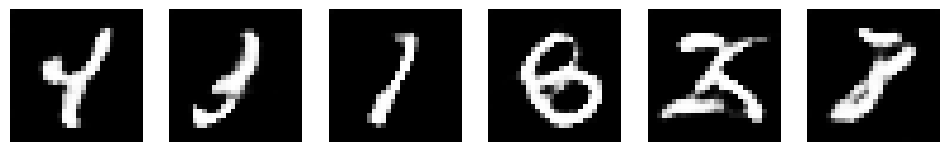

*** time now:  2023-06-01 17:49:37.911249
2/2 [==============================] - 0s 23ms/step
=== Iter: 15905 : d_loss_real: 0.632094145, d_loss_fake: 0.597269535, dcg_loss: 0.833640993 - in Epoch 17/20 - Batch 913/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 15910 : d_loss_real: 0.564742208, d_loss_fake: 0.702977657, dcg_loss: 0.836687088 - in Epoch 17/20 - Batch 918/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15915 : d_loss_real: 0.636264801, d_loss_fake: 0.628773570, dcg_loss: 0.815393686 - in Epoch 17/20 - Batch 923/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 15920 : d_loss_real: 0.637773931, d_loss_fake: 0.623674989, dcg_loss: 0.795871437 - in Epoch 17/20 - Batch 928/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 15925 : d_loss_real: 0.585712910, d_loss_fake: 0.627571166, dcg_loss: 0.810461462 - in Epoch 17/20 - Batch 933/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 15930 : d_l

2/2 [==============================] - 0s 19ms/step
=== Iter: 16115 : d_loss_real: 0.616219640, d_loss_fake: 0.618604004, dcg_loss: 0.932350397 - in Epoch 18/20 - Batch 186/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16120 : d_loss_real: 0.559137642, d_loss_fake: 0.655279338, dcg_loss: 0.874863982 - in Epoch 18/20 - Batch 191/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 16125 : d_loss_real: 0.656565368, d_loss_fake: 0.636779904, dcg_loss: 0.889852464 - in Epoch 18/20 - Batch 196/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 16130 : d_loss_real: 0.625880301, d_loss_fake: 0.663447499, dcg_loss: 0.756005943 - in Epoch 18/20 - Batch 201/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16135 : d_loss_real: 0.666670442, d_loss_fake: 0.726328790, dcg_loss: 0.873222649 - in Epoch 18/20 - Batch 206/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16140 : d_loss_real: 0.636827946, d_loss_fake: 0.6121

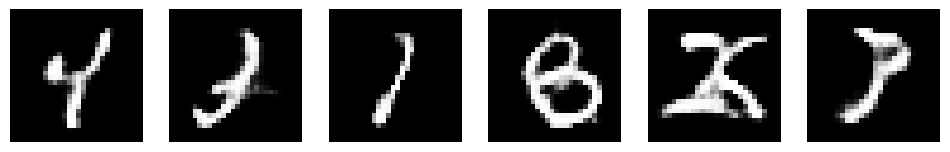

*** time now:  2023-06-01 17:51:06.862116
2/2 [==============================] - 0s 29ms/step
=== Iter: 16205 : d_loss_real: 0.669322789, d_loss_fake: 0.560348570, dcg_loss: 0.953337789 - in Epoch 18/20 - Batch 276/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 16210 : d_loss_real: 0.681528389, d_loss_fake: 0.583974004, dcg_loss: 0.936799943 - in Epoch 18/20 - Batch 281/937
2/2 [==============================] - 0s 27ms/step
=== Iter: 16215 : d_loss_real: 0.605655968, d_loss_fake: 0.580699563, dcg_loss: 0.987979710 - in Epoch 18/20 - Batch 286/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 16220 : d_loss_real: 0.574249983, d_loss_fake: 0.551956713, dcg_loss: 0.968586564 - in Epoch 18/20 - Batch 291/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 16225 : d_loss_real: 0.667040169, d_loss_fake: 0.640007615, dcg_loss: 0.934950829 - in Epoch 18/20 - Batch 296/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 16230 : d_l

2/2 [==============================] - 0s 20ms/step
=== Iter: 16415 : d_loss_real: 0.645699382, d_loss_fake: 0.617796779, dcg_loss: 0.924267411 - in Epoch 18/20 - Batch 486/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 16420 : d_loss_real: 0.712082326, d_loss_fake: 0.546829700, dcg_loss: 0.951453447 - in Epoch 18/20 - Batch 491/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16425 : d_loss_real: 0.699806094, d_loss_fake: 0.529780746, dcg_loss: 1.024320602 - in Epoch 18/20 - Batch 496/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 16430 : d_loss_real: 0.617248714, d_loss_fake: 0.592608631, dcg_loss: 0.953065395 - in Epoch 18/20 - Batch 501/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16435 : d_loss_real: 0.651844084, d_loss_fake: 0.539734542, dcg_loss: 1.053667545 - in Epoch 18/20 - Batch 506/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16440 : d_loss_real: 0.571044862, d_loss_fake: 0.5511

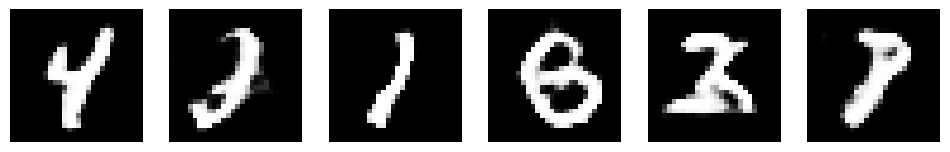

*** time now:  2023-06-01 17:52:29.715035
2/2 [==============================] - 0s 21ms/step
=== Iter: 16505 : d_loss_real: 0.567660511, d_loss_fake: 0.538979590, dcg_loss: 1.056021929 - in Epoch 18/20 - Batch 576/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 16510 : d_loss_real: 0.511224866, d_loss_fake: 0.509782076, dcg_loss: 0.996701658 - in Epoch 18/20 - Batch 581/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 16515 : d_loss_real: 0.539921284, d_loss_fake: 0.565249324, dcg_loss: 1.043805718 - in Epoch 18/20 - Batch 586/937
2/2 [==============================] - 0s 24ms/step
=== Iter: 16520 : d_loss_real: 0.584842563, d_loss_fake: 0.600442111, dcg_loss: 0.953174472 - in Epoch 18/20 - Batch 591/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 16525 : d_loss_real: 0.594765782, d_loss_fake: 0.669934809, dcg_loss: 0.852308154 - in Epoch 18/20 - Batch 596/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 16530 : d_l

2/2 [==============================] - 0s 16ms/step
=== Iter: 16715 : d_loss_real: 0.609433830, d_loss_fake: 0.678942263, dcg_loss: 0.805738866 - in Epoch 18/20 - Batch 786/937
2/2 [==============================] - 0s 16ms/step
=== Iter: 16720 : d_loss_real: 0.587165713, d_loss_fake: 0.637330294, dcg_loss: 0.792607546 - in Epoch 18/20 - Batch 791/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 16725 : d_loss_real: 0.642300010, d_loss_fake: 0.580729663, dcg_loss: 0.921798944 - in Epoch 18/20 - Batch 796/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 16730 : d_loss_real: 0.629824042, d_loss_fake: 0.610957205, dcg_loss: 0.928759098 - in Epoch 18/20 - Batch 801/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 16735 : d_loss_real: 0.619429231, d_loss_fake: 0.600016057, dcg_loss: 0.954790890 - in Epoch 18/20 - Batch 806/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 16740 : d_loss_real: 0.550293803, d_loss_fake: 0.6314

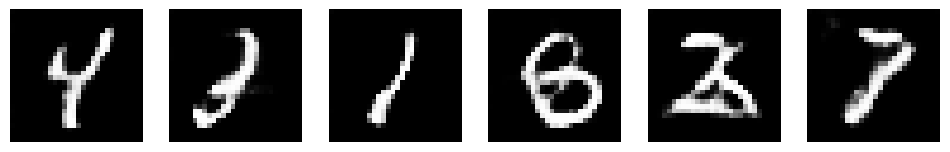

*** time now:  2023-06-01 17:53:57.760646
2/2 [==============================] - 0s 16ms/step
=== Iter: 16805 : d_loss_real: 0.587774634, d_loss_fake: 0.587709069, dcg_loss: 1.106186867 - in Epoch 18/20 - Batch 876/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 16810 : d_loss_real: 0.571306646, d_loss_fake: 0.644041538, dcg_loss: 0.891942203 - in Epoch 18/20 - Batch 881/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 16815 : d_loss_real: 0.589006305, d_loss_fake: 0.686413825, dcg_loss: 0.936288655 - in Epoch 18/20 - Batch 886/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 16820 : d_loss_real: 0.664841294, d_loss_fake: 0.678758383, dcg_loss: 0.856584847 - in Epoch 18/20 - Batch 891/937
2/2 [==============================] - 0s 18ms/step
=== Iter: 16825 : d_loss_real: 0.597237051, d_loss_fake: 0.695589662, dcg_loss: 0.879893541 - in Epoch 18/20 - Batch 896/937
2/2 [==============================] - 0s 17ms/step
=== Iter: 16830 : d_l

2/2 [==============================] - 0s 20ms/step
=== Iter: 17015 : d_loss_real: 0.653870940, d_loss_fake: 0.650740981, dcg_loss: 0.892993391 - in Epoch 19/20 - Batch 149/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 17020 : d_loss_real: 0.659042001, d_loss_fake: 0.553515077, dcg_loss: 0.920908093 - in Epoch 19/20 - Batch 154/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17025 : d_loss_real: 0.646529675, d_loss_fake: 0.623392463, dcg_loss: 0.902807713 - in Epoch 19/20 - Batch 159/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17030 : d_loss_real: 0.637967706, d_loss_fake: 0.538288474, dcg_loss: 1.097773910 - in Epoch 19/20 - Batch 164/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 17035 : d_loss_real: 0.613635480, d_loss_fake: 0.624402404, dcg_loss: 1.014174342 - in Epoch 19/20 - Batch 169/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17040 : d_loss_real: 0.570706010, d_loss_fake: 0.5751

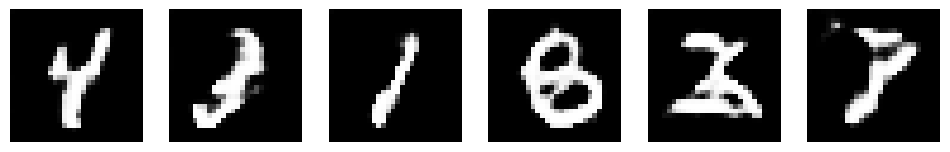

*** time now:  2023-06-01 17:55:21.306783
2/2 [==============================] - 0s 18ms/step
=== Iter: 17105 : d_loss_real: 0.549175739, d_loss_fake: 0.625026464, dcg_loss: 1.049990535 - in Epoch 19/20 - Batch 239/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17110 : d_loss_real: 0.570714116, d_loss_fake: 0.614690661, dcg_loss: 0.978568912 - in Epoch 19/20 - Batch 244/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17115 : d_loss_real: 0.601114690, d_loss_fake: 0.604489923, dcg_loss: 0.953626871 - in Epoch 19/20 - Batch 249/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17120 : d_loss_real: 0.578965306, d_loss_fake: 0.594660997, dcg_loss: 0.964740038 - in Epoch 19/20 - Batch 254/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17125 : d_loss_real: 0.691970587, d_loss_fake: 0.582118630, dcg_loss: 0.979022622 - in Epoch 19/20 - Batch 259/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17130 : d_l

2/2 [==============================] - 0s 23ms/step
=== Iter: 17315 : d_loss_real: 0.579930663, d_loss_fake: 0.584712863, dcg_loss: 0.871415615 - in Epoch 19/20 - Batch 449/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17320 : d_loss_real: 0.605473459, d_loss_fake: 0.663386226, dcg_loss: 0.887483954 - in Epoch 19/20 - Batch 454/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17325 : d_loss_real: 0.608707309, d_loss_fake: 0.646969676, dcg_loss: 0.894952655 - in Epoch 19/20 - Batch 459/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 17330 : d_loss_real: 0.695000827, d_loss_fake: 0.610154152, dcg_loss: 0.856319904 - in Epoch 19/20 - Batch 464/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 17335 : d_loss_real: 0.536598861, d_loss_fake: 0.614692450, dcg_loss: 0.818746448 - in Epoch 19/20 - Batch 469/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 17340 : d_loss_real: 0.690930545, d_loss_fake: 0.6125

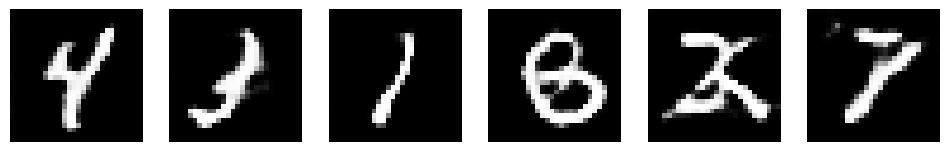

*** time now:  2023-06-01 17:56:42.630473
2/2 [==============================] - 0s 21ms/step
=== Iter: 17405 : d_loss_real: 0.585169256, d_loss_fake: 0.608837724, dcg_loss: 0.895395875 - in Epoch 19/20 - Batch 539/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17410 : d_loss_real: 0.637568712, d_loss_fake: 0.612599015, dcg_loss: 0.829312682 - in Epoch 19/20 - Batch 544/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17415 : d_loss_real: 0.649036050, d_loss_fake: 0.629182696, dcg_loss: 0.953878284 - in Epoch 19/20 - Batch 549/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17420 : d_loss_real: 0.609049797, d_loss_fake: 0.694403887, dcg_loss: 0.783199251 - in Epoch 19/20 - Batch 554/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17425 : d_loss_real: 0.607838452, d_loss_fake: 0.756391048, dcg_loss: 0.876633227 - in Epoch 19/20 - Batch 559/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17430 : d_l

2/2 [==============================] - 0s 19ms/step
=== Iter: 17615 : d_loss_real: 0.662866235, d_loss_fake: 0.650838852, dcg_loss: 0.981645823 - in Epoch 19/20 - Batch 749/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17620 : d_loss_real: 0.591550052, d_loss_fake: 0.569786549, dcg_loss: 0.926279664 - in Epoch 19/20 - Batch 754/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17625 : d_loss_real: 0.653285027, d_loss_fake: 0.634632707, dcg_loss: 0.902926981 - in Epoch 19/20 - Batch 759/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17630 : d_loss_real: 0.604592264, d_loss_fake: 0.641335011, dcg_loss: 0.907783389 - in Epoch 19/20 - Batch 764/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17635 : d_loss_real: 0.644608855, d_loss_fake: 0.591836154, dcg_loss: 0.888237834 - in Epoch 19/20 - Batch 769/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17640 : d_loss_real: 0.668030500, d_loss_fake: 0.7011

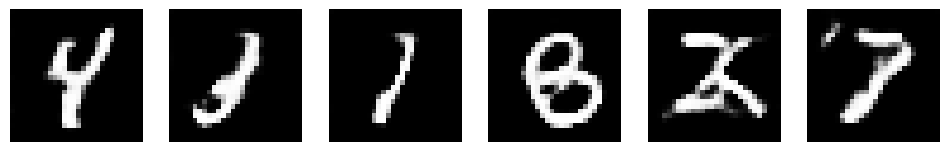

*** time now:  2023-06-01 17:58:01.553096
2/2 [==============================] - 0s 19ms/step
=== Iter: 17705 : d_loss_real: 0.682151437, d_loss_fake: 0.603851914, dcg_loss: 0.849405885 - in Epoch 19/20 - Batch 839/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17710 : d_loss_real: 0.679426074, d_loss_fake: 0.598639786, dcg_loss: 0.940028071 - in Epoch 19/20 - Batch 844/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17715 : d_loss_real: 0.685453951, d_loss_fake: 0.550313115, dcg_loss: 0.915654361 - in Epoch 19/20 - Batch 849/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 17720 : d_loss_real: 0.681928873, d_loss_fake: 0.595238268, dcg_loss: 0.875703454 - in Epoch 19/20 - Batch 854/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17725 : d_loss_real: 0.572079062, d_loss_fake: 0.650064051, dcg_loss: 0.956125140 - in Epoch 19/20 - Batch 859/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 17730 : d_l

2/2 [==============================] - 0s 21ms/step
=== Iter: 17915 : d_loss_real: 0.588968337, d_loss_fake: 0.620397568, dcg_loss: 0.942224681 - in Epoch 20/20 - Batch 112/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17920 : d_loss_real: 0.599880338, d_loss_fake: 0.599176586, dcg_loss: 0.841837049 - in Epoch 20/20 - Batch 117/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17925 : d_loss_real: 0.709596753, d_loss_fake: 0.564554214, dcg_loss: 0.915968299 - in Epoch 20/20 - Batch 122/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 17930 : d_loss_real: 0.646729290, d_loss_fake: 0.625373840, dcg_loss: 0.983184814 - in Epoch 20/20 - Batch 127/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17935 : d_loss_real: 0.707207799, d_loss_fake: 0.540143251, dcg_loss: 1.031715393 - in Epoch 20/20 - Batch 132/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 17940 : d_loss_real: 0.602912426, d_loss_fake: 0.5545

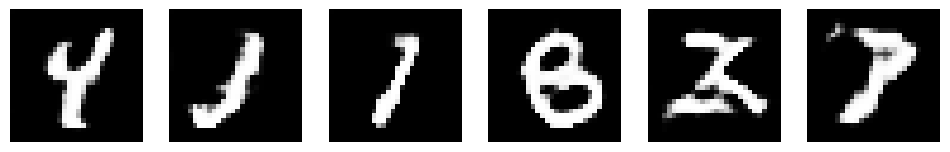

*** time now:  2023-06-01 17:59:31.424925
2/2 [==============================] - 0s 23ms/step
=== Iter: 18005 : d_loss_real: 0.559045374, d_loss_fake: 0.578868985, dcg_loss: 0.940930367 - in Epoch 20/20 - Batch 202/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 18010 : d_loss_real: 0.554715872, d_loss_fake: 0.586461246, dcg_loss: 0.838295698 - in Epoch 20/20 - Batch 207/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 18015 : d_loss_real: 0.639988005, d_loss_fake: 0.593921006, dcg_loss: 0.906442821 - in Epoch 20/20 - Batch 212/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 18020 : d_loss_real: 0.559898257, d_loss_fake: 0.600737214, dcg_loss: 0.904959023 - in Epoch 20/20 - Batch 217/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 18025 : d_loss_real: 0.636454821, d_loss_fake: 0.634556472, dcg_loss: 1.019714952 - in Epoch 20/20 - Batch 222/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 18030 : d_l

2/2 [==============================] - 0s 22ms/step
=== Iter: 18215 : d_loss_real: 0.641381860, d_loss_fake: 0.572584987, dcg_loss: 0.823974848 - in Epoch 20/20 - Batch 412/937
2/2 [==============================] - 0s 28ms/step
=== Iter: 18220 : d_loss_real: 0.571186066, d_loss_fake: 0.635653973, dcg_loss: 0.926203728 - in Epoch 20/20 - Batch 417/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 18225 : d_loss_real: 0.614211321, d_loss_fake: 0.657792628, dcg_loss: 0.932589471 - in Epoch 20/20 - Batch 422/937
2/2 [==============================] - 0s 23ms/step
=== Iter: 18230 : d_loss_real: 0.640136182, d_loss_fake: 0.586999655, dcg_loss: 0.942862928 - in Epoch 20/20 - Batch 427/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 18235 : d_loss_real: 0.562457740, d_loss_fake: 0.548786879, dcg_loss: 0.880876005 - in Epoch 20/20 - Batch 432/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 18240 : d_loss_real: 0.631673038, d_loss_fake: 0.5573

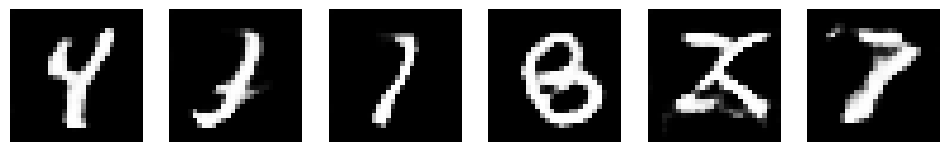

*** time now:  2023-06-01 18:01:33.133937
2/2 [==============================] - 0s 22ms/step
=== Iter: 18305 : d_loss_real: 0.670412421, d_loss_fake: 0.640280008, dcg_loss: 0.951925159 - in Epoch 20/20 - Batch 502/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18310 : d_loss_real: 0.619359076, d_loss_fake: 0.605683982, dcg_loss: 0.882895708 - in Epoch 20/20 - Batch 507/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18315 : d_loss_real: 0.615598679, d_loss_fake: 0.624887168, dcg_loss: 0.940679252 - in Epoch 20/20 - Batch 512/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18320 : d_loss_real: 0.605820179, d_loss_fake: 0.575995445, dcg_loss: 0.924119353 - in Epoch 20/20 - Batch 517/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18325 : d_loss_real: 0.679244876, d_loss_fake: 0.583990991, dcg_loss: 0.898095965 - in Epoch 20/20 - Batch 522/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18330 : d_l

2/2 [==============================] - 0s 21ms/step
=== Iter: 18515 : d_loss_real: 0.626015902, d_loss_fake: 0.661745369, dcg_loss: 0.769195795 - in Epoch 20/20 - Batch 712/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 18520 : d_loss_real: 0.617244363, d_loss_fake: 0.736571848, dcg_loss: 0.804756999 - in Epoch 20/20 - Batch 717/937
2/2 [==============================] - 0s 19ms/step
=== Iter: 18525 : d_loss_real: 0.669655740, d_loss_fake: 0.580204725, dcg_loss: 0.872799456 - in Epoch 20/20 - Batch 722/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18530 : d_loss_real: 0.583830118, d_loss_fake: 0.566511512, dcg_loss: 0.896096051 - in Epoch 20/20 - Batch 727/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18535 : d_loss_real: 0.591783166, d_loss_fake: 0.652264178, dcg_loss: 0.838289142 - in Epoch 20/20 - Batch 732/937
2/2 [==============================] - 0s 20ms/step
=== Iter: 18540 : d_loss_real: 0.676261842, d_loss_fake: 0.6240

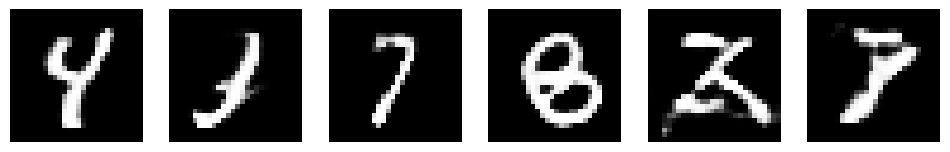

*** time now:  2023-06-01 18:02:52.589811
2/2 [==============================] - 0s 21ms/step
=== Iter: 18605 : d_loss_real: 0.600319684, d_loss_fake: 0.590709507, dcg_loss: 0.943298638 - in Epoch 20/20 - Batch 802/937
2/2 [==============================] - 0s 22ms/step
=== Iter: 18610 : d_loss_real: 0.599576533, d_loss_fake: 0.547096908, dcg_loss: 0.875005543 - in Epoch 20/20 - Batch 807/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 18615 : d_loss_real: 0.626636147, d_loss_fake: 0.695960224, dcg_loss: 0.817608356 - in Epoch 20/20 - Batch 812/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 18620 : d_loss_real: 0.660294056, d_loss_fake: 0.570162177, dcg_loss: 0.956901610 - in Epoch 20/20 - Batch 817/937
2/2 [==============================] - 0s 25ms/step
=== Iter: 18625 : d_loss_real: 0.635993421, d_loss_fake: 0.609085917, dcg_loss: 0.889575303 - in Epoch 20/20 - Batch 822/937
2/2 [==============================] - 0s 21ms/step
=== Iter: 18630 : d_l

In [44]:
## Start Model Training in the iterations

## Record the Starting time of runing DCGAN training
datetime_now = datetime.now()
print(f"~~~ DCGAN training starting at {datetime_now} \n\n ")  

for epoch in range(0, EPOCHS): 
    ## generate new dataset of real images for each epoch
    real_dataset = get_dataset_real(images_data)
    
    for batch, images_real in enumerate(real_dataset):
        
        ## Train Discriminator seperately:
        
        ## Make Discriminator Trainable for now
        ##   i.e.set the Discriminator Model trainable to be trained on real and fake images
        discriminator.trainable = True     
        
        ## Batch Train Discriminator Model on a batch of real images with them labeled as real 
        d_loss_real = discriminator.train_on_batch(images_real, labels_real)
        
        ## create a random noise batch inputs and pass which into the Generator to generate fake images
        noise_inputs = get_noise_one_batch()
        images_fake = generator.predict(noise_inputs)
                          
        ## Train Discriminator Model on a batch of fake images with them labeled as fake 
        d_loss_fake = discriminator.train_on_batch(images_fake, labels_fake)
                          
            
        ## Train DCGAN model     
        
        ## Make Discriminator Not-trainable for now
        ##   i.e. set the Discriminator Model NOT trainable 
        ##        to only update layer weights of Generator            
        discriminator.trainable = False  

        ## create a random noise batch inputs and pass which into the DCGAN later
        noise_inputs = get_noise_one_batch()
        
        ## Batch Train DCGAN Model on a batch of noise inputs with them labeled as real 
        ##   to fool the Discriminator with the fake images generated by Generator but labeled as real
        dcg_loss = dcgan.train_on_batch(noise_inputs, labels_real) 
    
        ## Print training progress with model losses  on the intervals  
        ##   and Show fake images generated on same 6 noise inputs 
        ##            which are also saved in the folder for comparison later
        iteration = (epoch * BATCHS) + (batch + 1)  

        if iteration % 5 == 0:
            print(f"=== Iter: {iteration} : d_loss_real: {d_loss_real:.9f}, d_loss_fake: {d_loss_fake:.9f}, dcg_loss: {dcg_loss:.9f} - in Epoch {epoch + 1}/{EPOCHS} - Batch {batch+1}/{BATCHS}")

        if iteration % iter_interval == 0: 
            images_check = generator.predict(noise_inputs_check)
            images_show(images_check, num_postfix=iteration)
            print("*** time now: ", datetime.now()) 
            
## Record the Ending time of runing DCGAN training
datetime_now = datetime.now()
print(f"\n\n ~~~ DCGAN trainging ends at {datetime_now}")  